**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 9 - Classification and Regression Trees, Random Forest, Boosting**</font>

# Libraries

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, classification_report

In [4]:
import statsmodels.api as sm

In [5]:
np.random.seed(1234)

In [6]:
import scipy.stats as stats

# Load Dataset

In [7]:
df = pd.read_csv('../DatasetsLabs/heart_failure_clinical_records_dataset_smhd.csv')

In [8]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time']#, 'rehospitalizations']

# Decision Trees

Train Accuracy: 0.98
Test Accuracy:  0.97
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



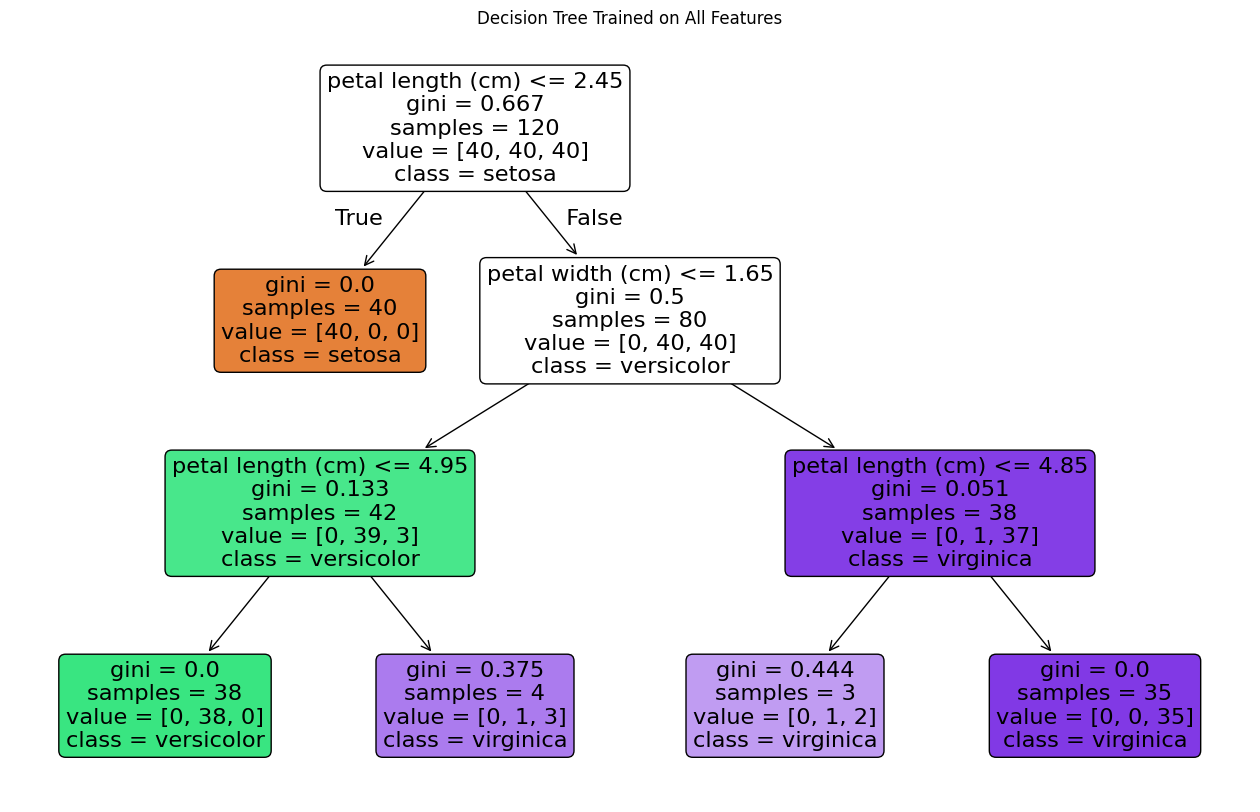

In [9]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D

# Load data
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Train decision tree using all features
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy:  {test_acc:.2f}")
print(classification_report(y_test, y_pred, target_names=target_names))

# Tree Visualization
plt.figure(figsize=(16, 10))
plot_tree(clf, feature_names=feature_names, class_names=target_names, filled=True, rounded=True)
plt.title("Decision Tree Trained on All Features")
plt.show()

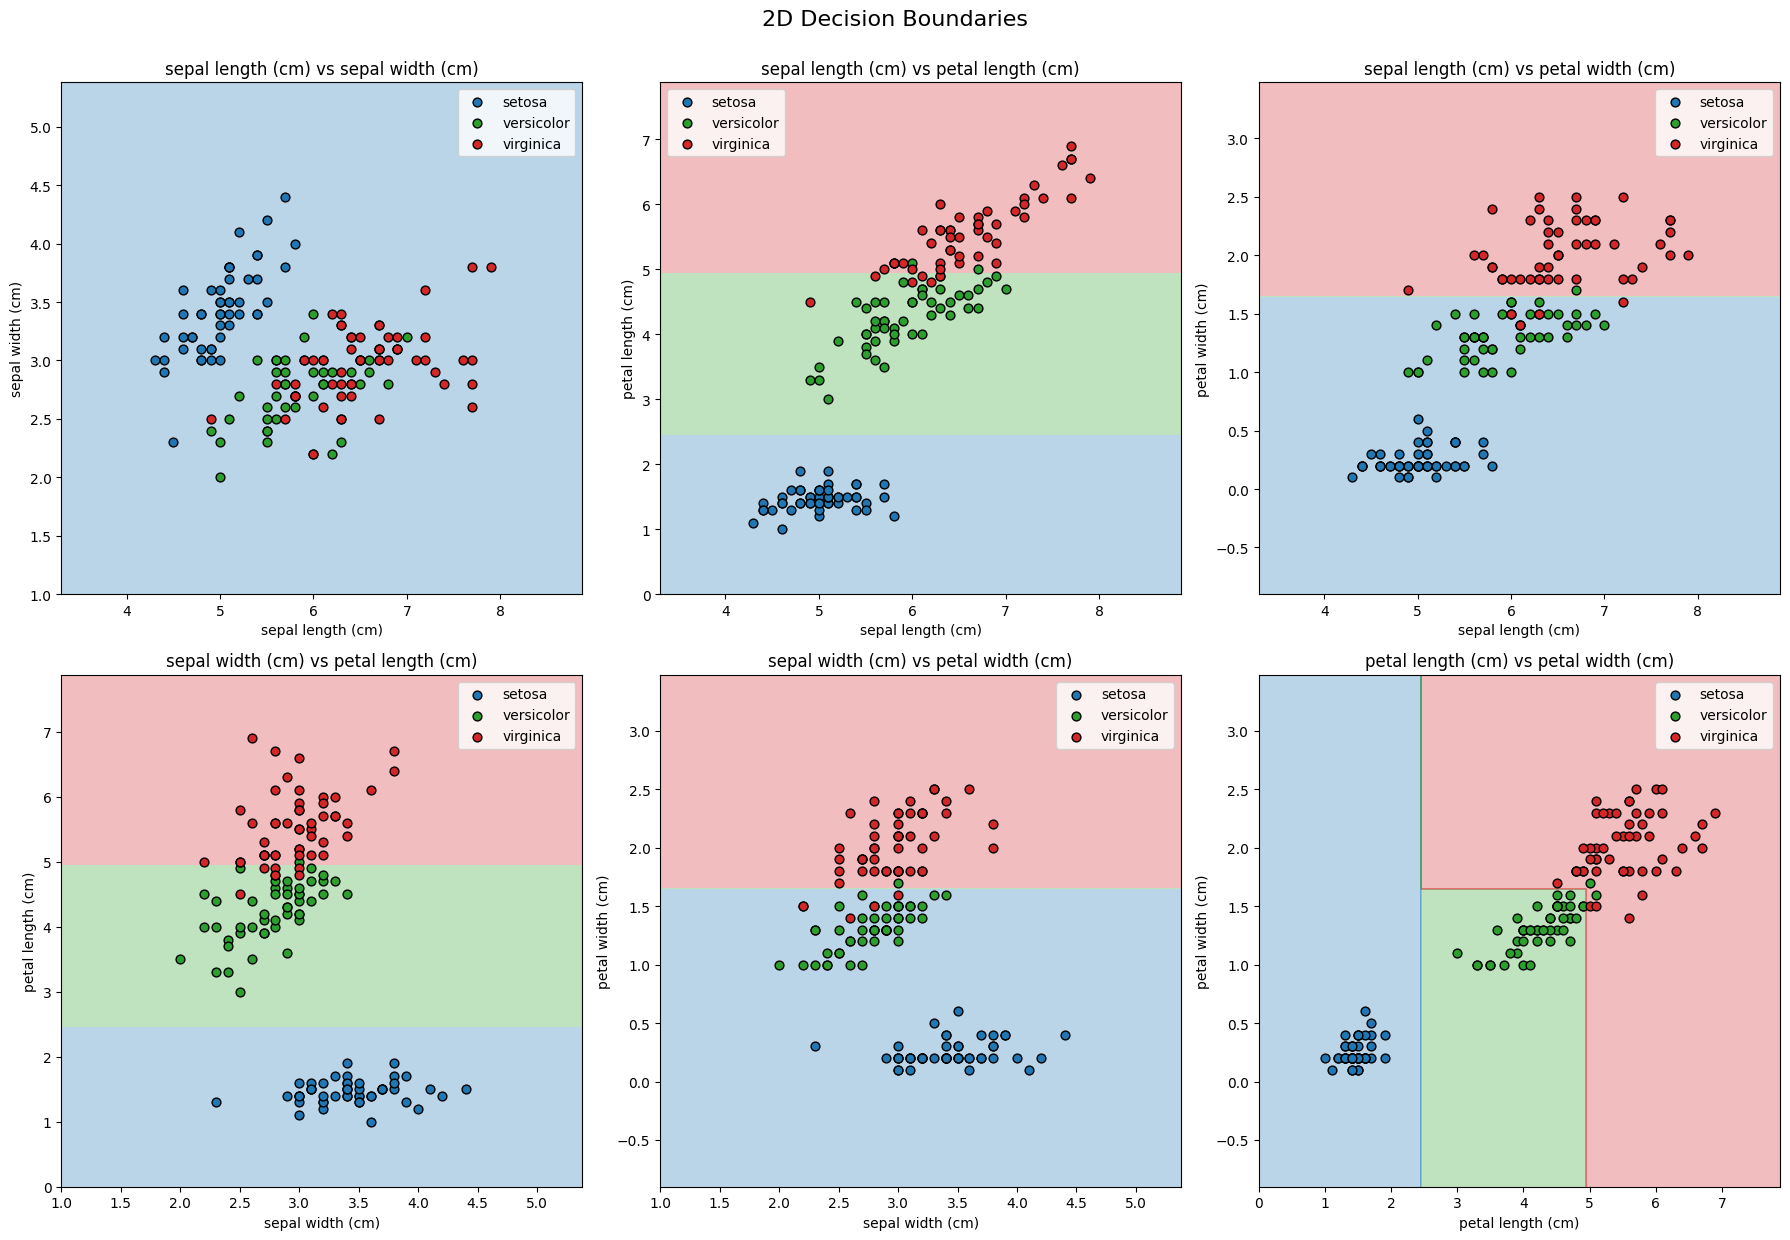

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib.colors import ListedColormap

# Define class-specific colors
class_colors = ['#1f77b4', '#2ca02c', '#d62728']  # blue, green, red
cmap_light = ListedColormap(class_colors)

# All feature pairs
pairs = list(itertools.combinations(range(X.shape[1]), 2))
plot_step = 0.02
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Create mesh for the selected feature pair
    x_min, x_max = X[:, i].min() - 1, X[:, i].max() + 1
    y_min, y_max = X[:, j].min() - 1, X[:, j].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    # Input for prediction (other features fixed)
    X_slice = np.zeros((xx.ravel().shape[0], X.shape[1]))
    X_slice[:, i] = xx.ravel()
    X_slice[:, j] = yy.ravel()
    for k in range(X.shape[1]):
        if k != i and k != j:
            X_slice[:, k] = X[:, k].mean()

    Z = clf.predict(X_slice).reshape(xx.shape)

    # Plot decision surface
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

    # Plot data points
    for class_idx, class_color in enumerate(class_colors):
        ax.scatter(X[y == class_idx, i],
                   X[y == class_idx, j],
                   label=target_names[class_idx],
                   c=class_color, edgecolor='k', s=40)

    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f"{feature_names[i]} vs {feature_names[j]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("2D Decision Boundaries", fontsize=16, y=1.03)
plt.show()


Different criteria can be used to decide where to split:

$$\text{Gini}(t) = 1 - \sum_{i=1}^{C} p_i^2$$

$$\Delta \text{Gini} = \text{Gini}_{\text{parent}} - \left( \frac{N_L}{N} \cdot \text{Gini}_L + \frac{N_R}{N} \cdot \text{Gini}_R \right)$$

$$\text{Entropy}(t) = -\sum_{i=1}^{C} p_i \log_2 p_i
$$

$$\text{Information Gain} = \text{Entropy}_{\text{parent}} - \left( \frac{N_L}{N} \cdot \text{Entropy}_L + \frac{N_R}{N} \cdot \text{Entropy}_R \right)
$$

Both measures are biased toward variables with many levels




In [11]:
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

clf_gini.fit(X_train, y_train)
clf_entropy.fit(X_train, y_train)

print(f"Gini Test Accuracy:    {accuracy_score(y_test, clf_gini.predict(X_test)):.2f}")
print(f"Entropy Test Accuracy: {accuracy_score(y_test, clf_entropy.predict(X_test)):.2f}")


Gini Test Accuracy:    0.97
Entropy Test Accuracy: 0.97


We can measure feature importance as the (weighted) sum of the delta gini / entropy in all nodes in which it was used

$$
\text{Importance of feature } j = \sum_{\text{nodes } t \text{ using } j} \frac{N_t}{N} \cdot \Delta \text{Impurity}_t
$$

In [12]:
importances = clf.feature_importances_
for name, score in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name:25s}: {score:.3f}")


petal length (cm)        : 0.579
petal width (cm)         : 0.421
sepal length (cm)        : 0.000
sepal width (cm)         : 0.000


## Depth control

Depth of the tree is a critical parameter:

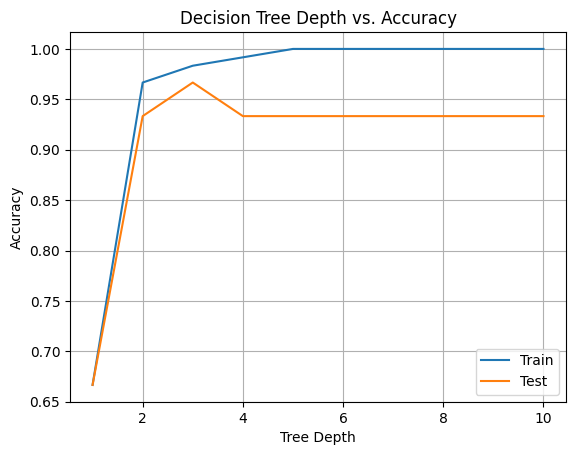

In [13]:
depths = range(1, 11)
train_scores = []
test_scores = []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

plt.plot(depths, train_scores, label="Train")
plt.plot(depths, test_scores, label="Test")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree Depth vs. Accuracy")
plt.legend()
plt.grid(True)
plt.show()


If you want to to the pruning during fitting:

In [14]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas[:-1]  # skip last (trivial) tree

for alpha in alphas:
    clf_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf_pruned.fit(X_train, y_train)
    print(f"Alpha: {alpha:.5f} | Test Accuracy: {clf_pruned.score(X_test, y_test):.3f}")


Alpha: 0.00000 | Test Accuracy: 0.933
Alpha: 0.00625 | Test Accuracy: 0.967
Alpha: 0.00811 | Test Accuracy: 0.967
Alpha: 0.03393 | Test Accuracy: 0.933
Alpha: 0.27068 | Test Accuracy: 0.667


`clf.cost_complexity_pruning_path(X_train, y_train)` returns the effective alphas (regularization strengths) at which:

*   Removing a branch would minimally increase the total impurity
*   But reduce model complexity (number of leaves)

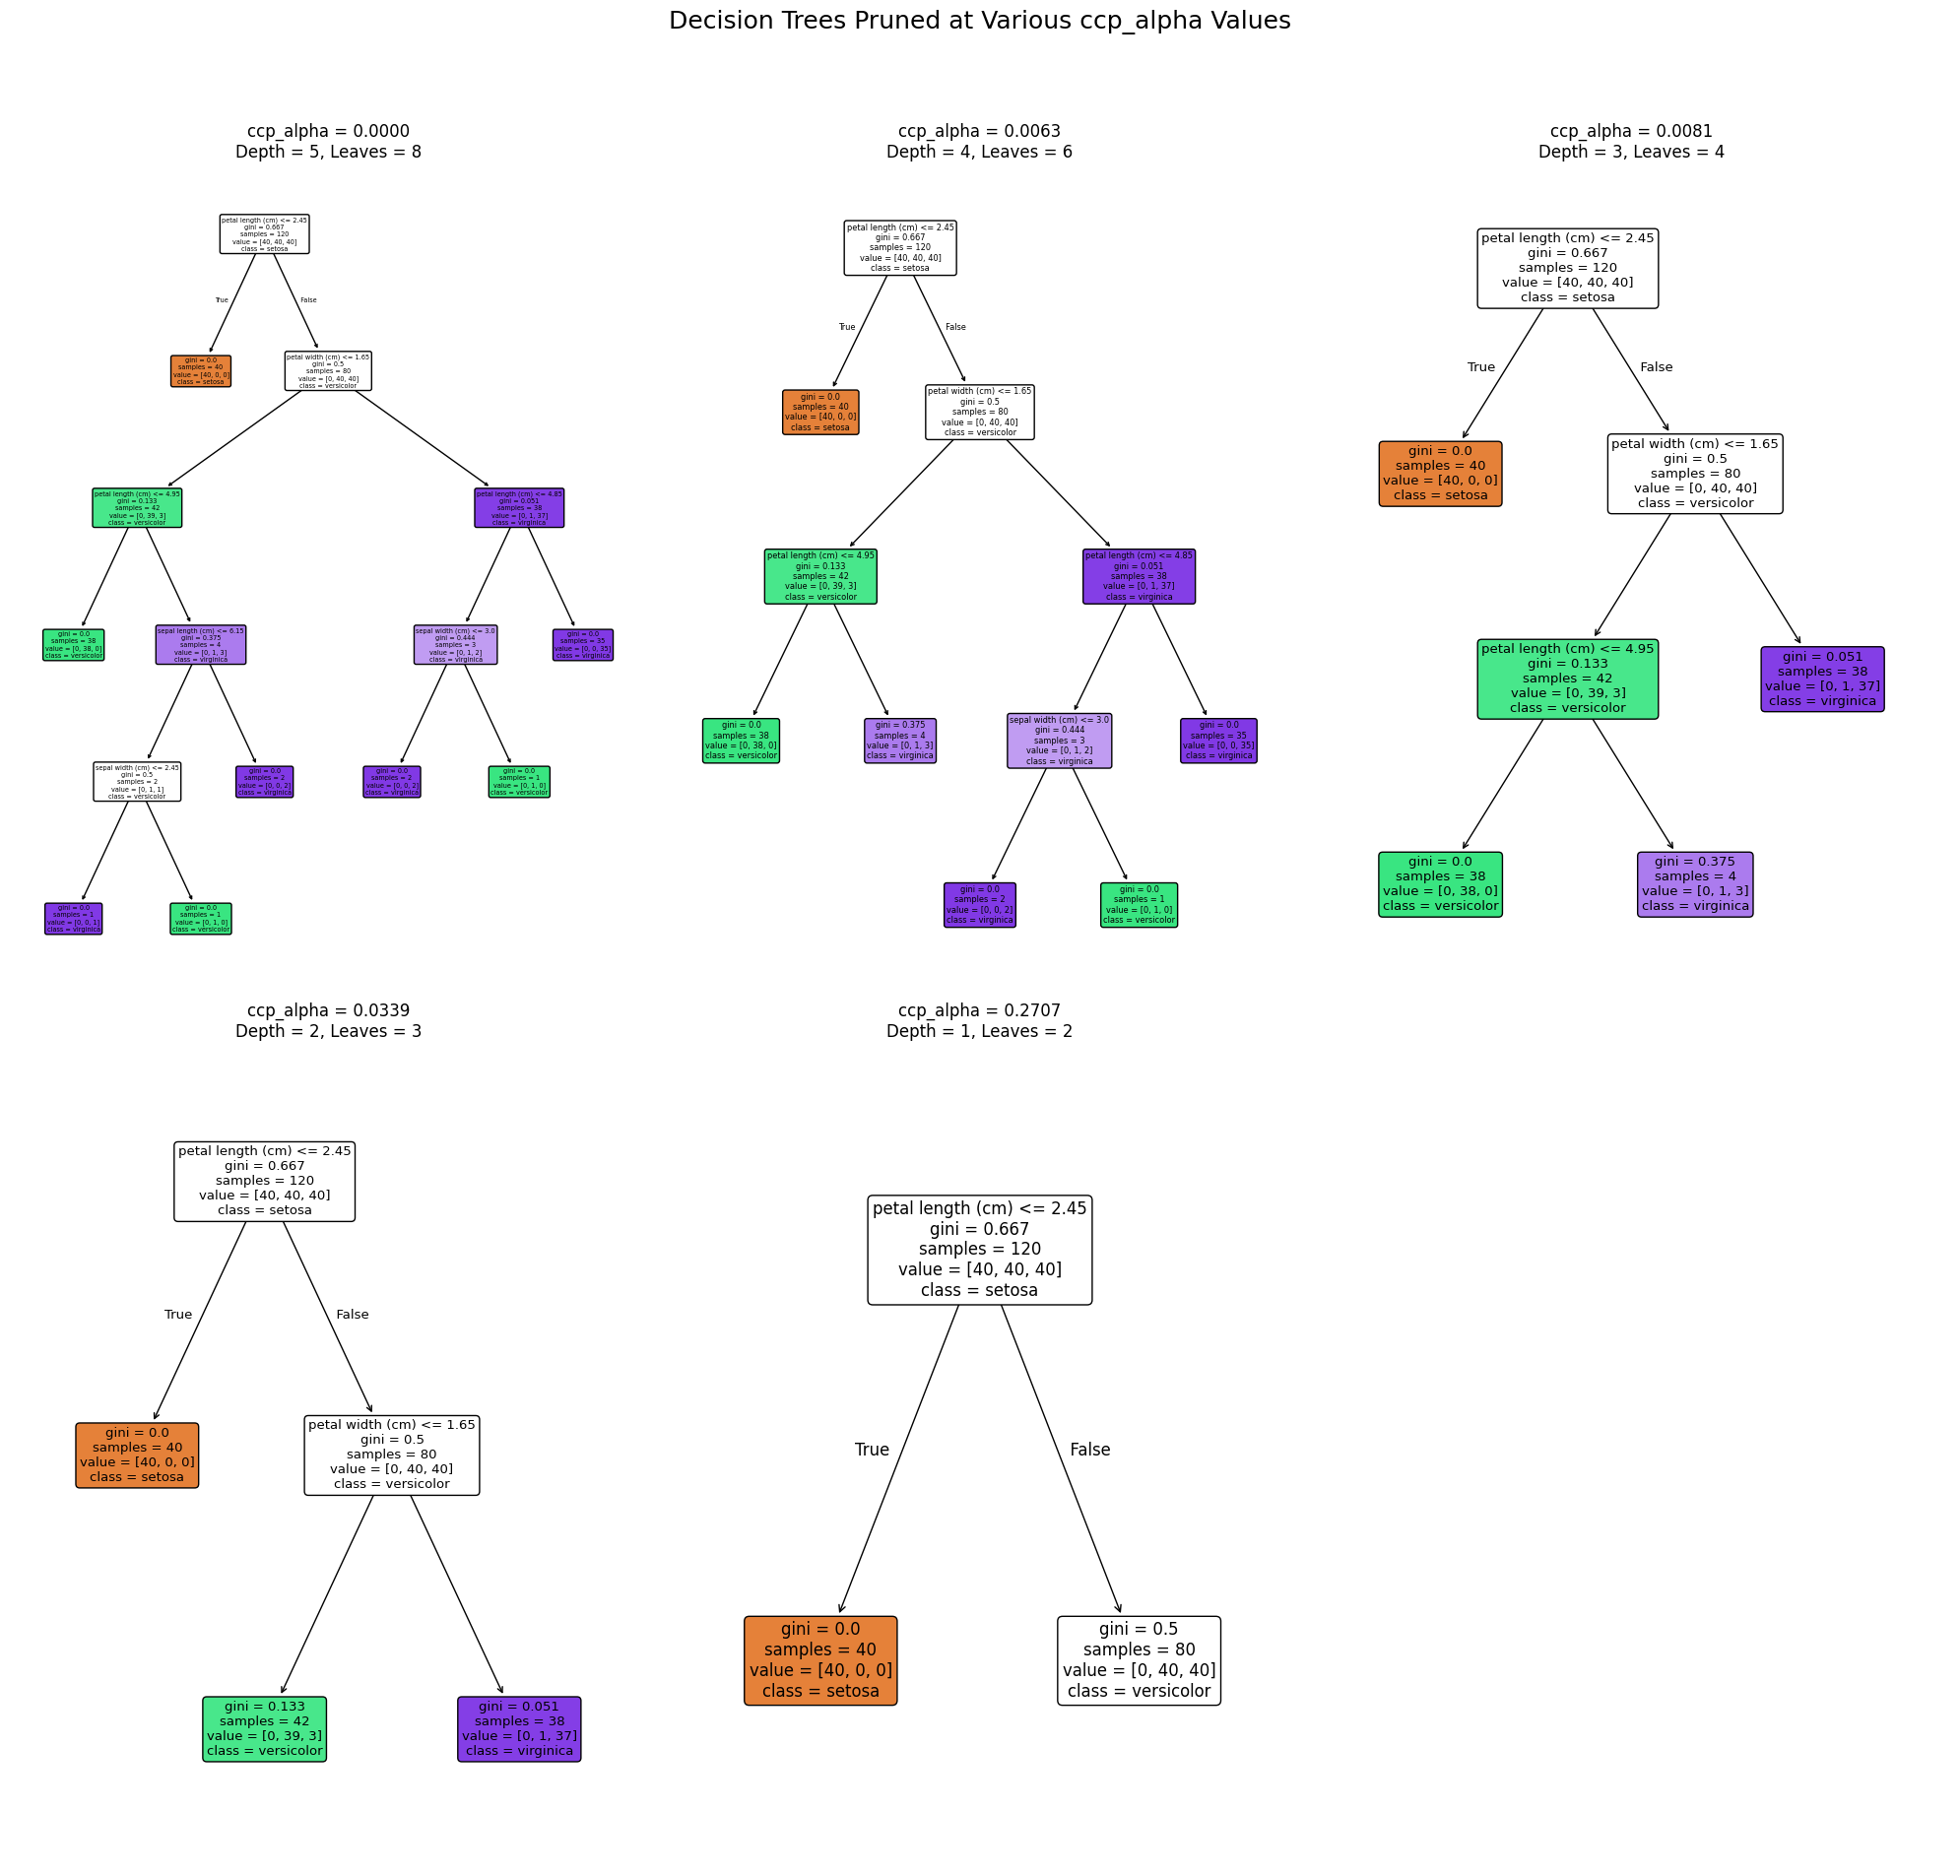

In [15]:
# Get pruning path
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # exclude the last alpha (always leads to root-only tree)

# Train a tree for each alpha
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Plot the trees for a selected subset of alpha values
n_trees_to_plot = min(6, len(clfs))  # limit to 6 for clarity
indices_to_plot = np.linspace(0, len(clfs) - 1, n_trees_to_plot, dtype=int)

plt.figure(figsize=(20, 20))
for i, idx in enumerate(indices_to_plot):
    clf = clfs[idx]
    plt.subplot(2, 3, i + 1)
    plot_tree(clf,
              filled=True,
              rounded=True,
              class_names=target_names,
              feature_names=feature_names)
    plt.title(f"ccp_alpha = {ccp_alphas[idx]:.4f}\nDepth = {clf.get_depth()}, Leaves = {clf.get_n_leaves()}")
plt.suptitle("Decision Trees Pruned at Various ccp_alpha Values", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Selection of ccp_alpha can be done via CV:

Best ccp_alpha: 0.00000 with CV accuracy: 0.9417
Test accuracy of pruned tree: 0.9333


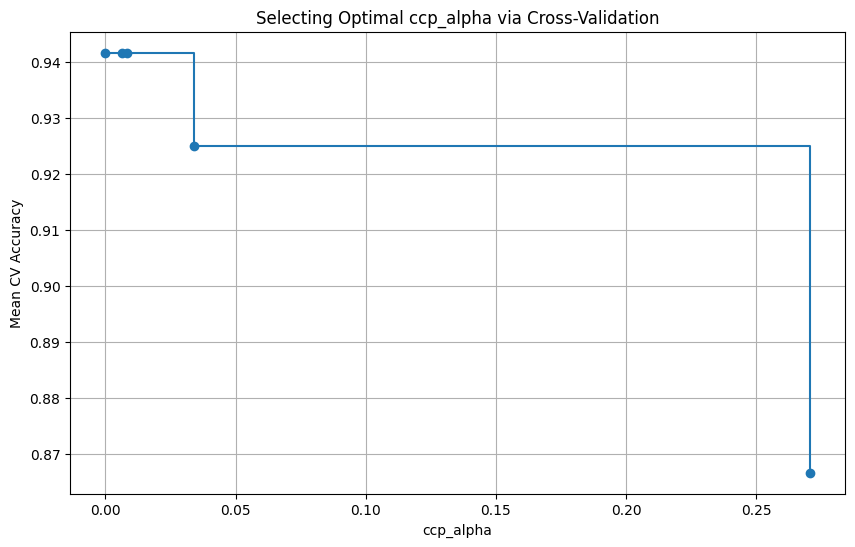

In [16]:
from sklearn.model_selection import cross_val_score

# Step 1: Get pruning path
clf = DecisionTreeClassifier(random_state=1234)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # skip the last one (trivial tree)

# Step 2: Train trees with different alphas + CV
clfs = []
cv_scores = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    clfs.append(clf)
    cv_scores.append(scores.mean())

# Step 3: Select best alpha
best_idx = np.argmax(cv_scores)
best_alpha = ccp_alphas[best_idx]
print(f"Best ccp_alpha: {best_alpha:.5f} with CV accuracy: {cv_scores[best_idx]:.4f}")

# Step 4: Retrain final model on full training set with best alpha
final_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_tree.fit(X_train, y_train)

# Evaluate on test set
test_acc = final_tree.score(X_test, y_test)
print(f"Test accuracy of pruned tree: {test_acc:.4f}")

# Step 5: Plot alpha vs. CV accuracy
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, cv_scores, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Mean CV Accuracy")
plt.title("Selecting Optimal ccp_alpha via Cross-Validation")
plt.grid(True)
plt.show()

# Regression Tree

In [17]:
from sklearn.tree import DecisionTreeRegressor

# Separate features/target
X = df.drop(columns='ejection_fraction')
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first'), categorical_vars)
])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42, max_depth=4))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Adjusted R²
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = preprocessor.fit(X_train).transform(X_train).shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score:       {r2:.3f}")
print(f"Adjusted R²:    {adj_r2:.3f}")
print(f"MSE:            {mse:.3f}")
print(f"MAE:            {mae:.3f}")


R² Score:       0.363
Adjusted R²:    0.183
MSE:            110.892
MAE:            7.924


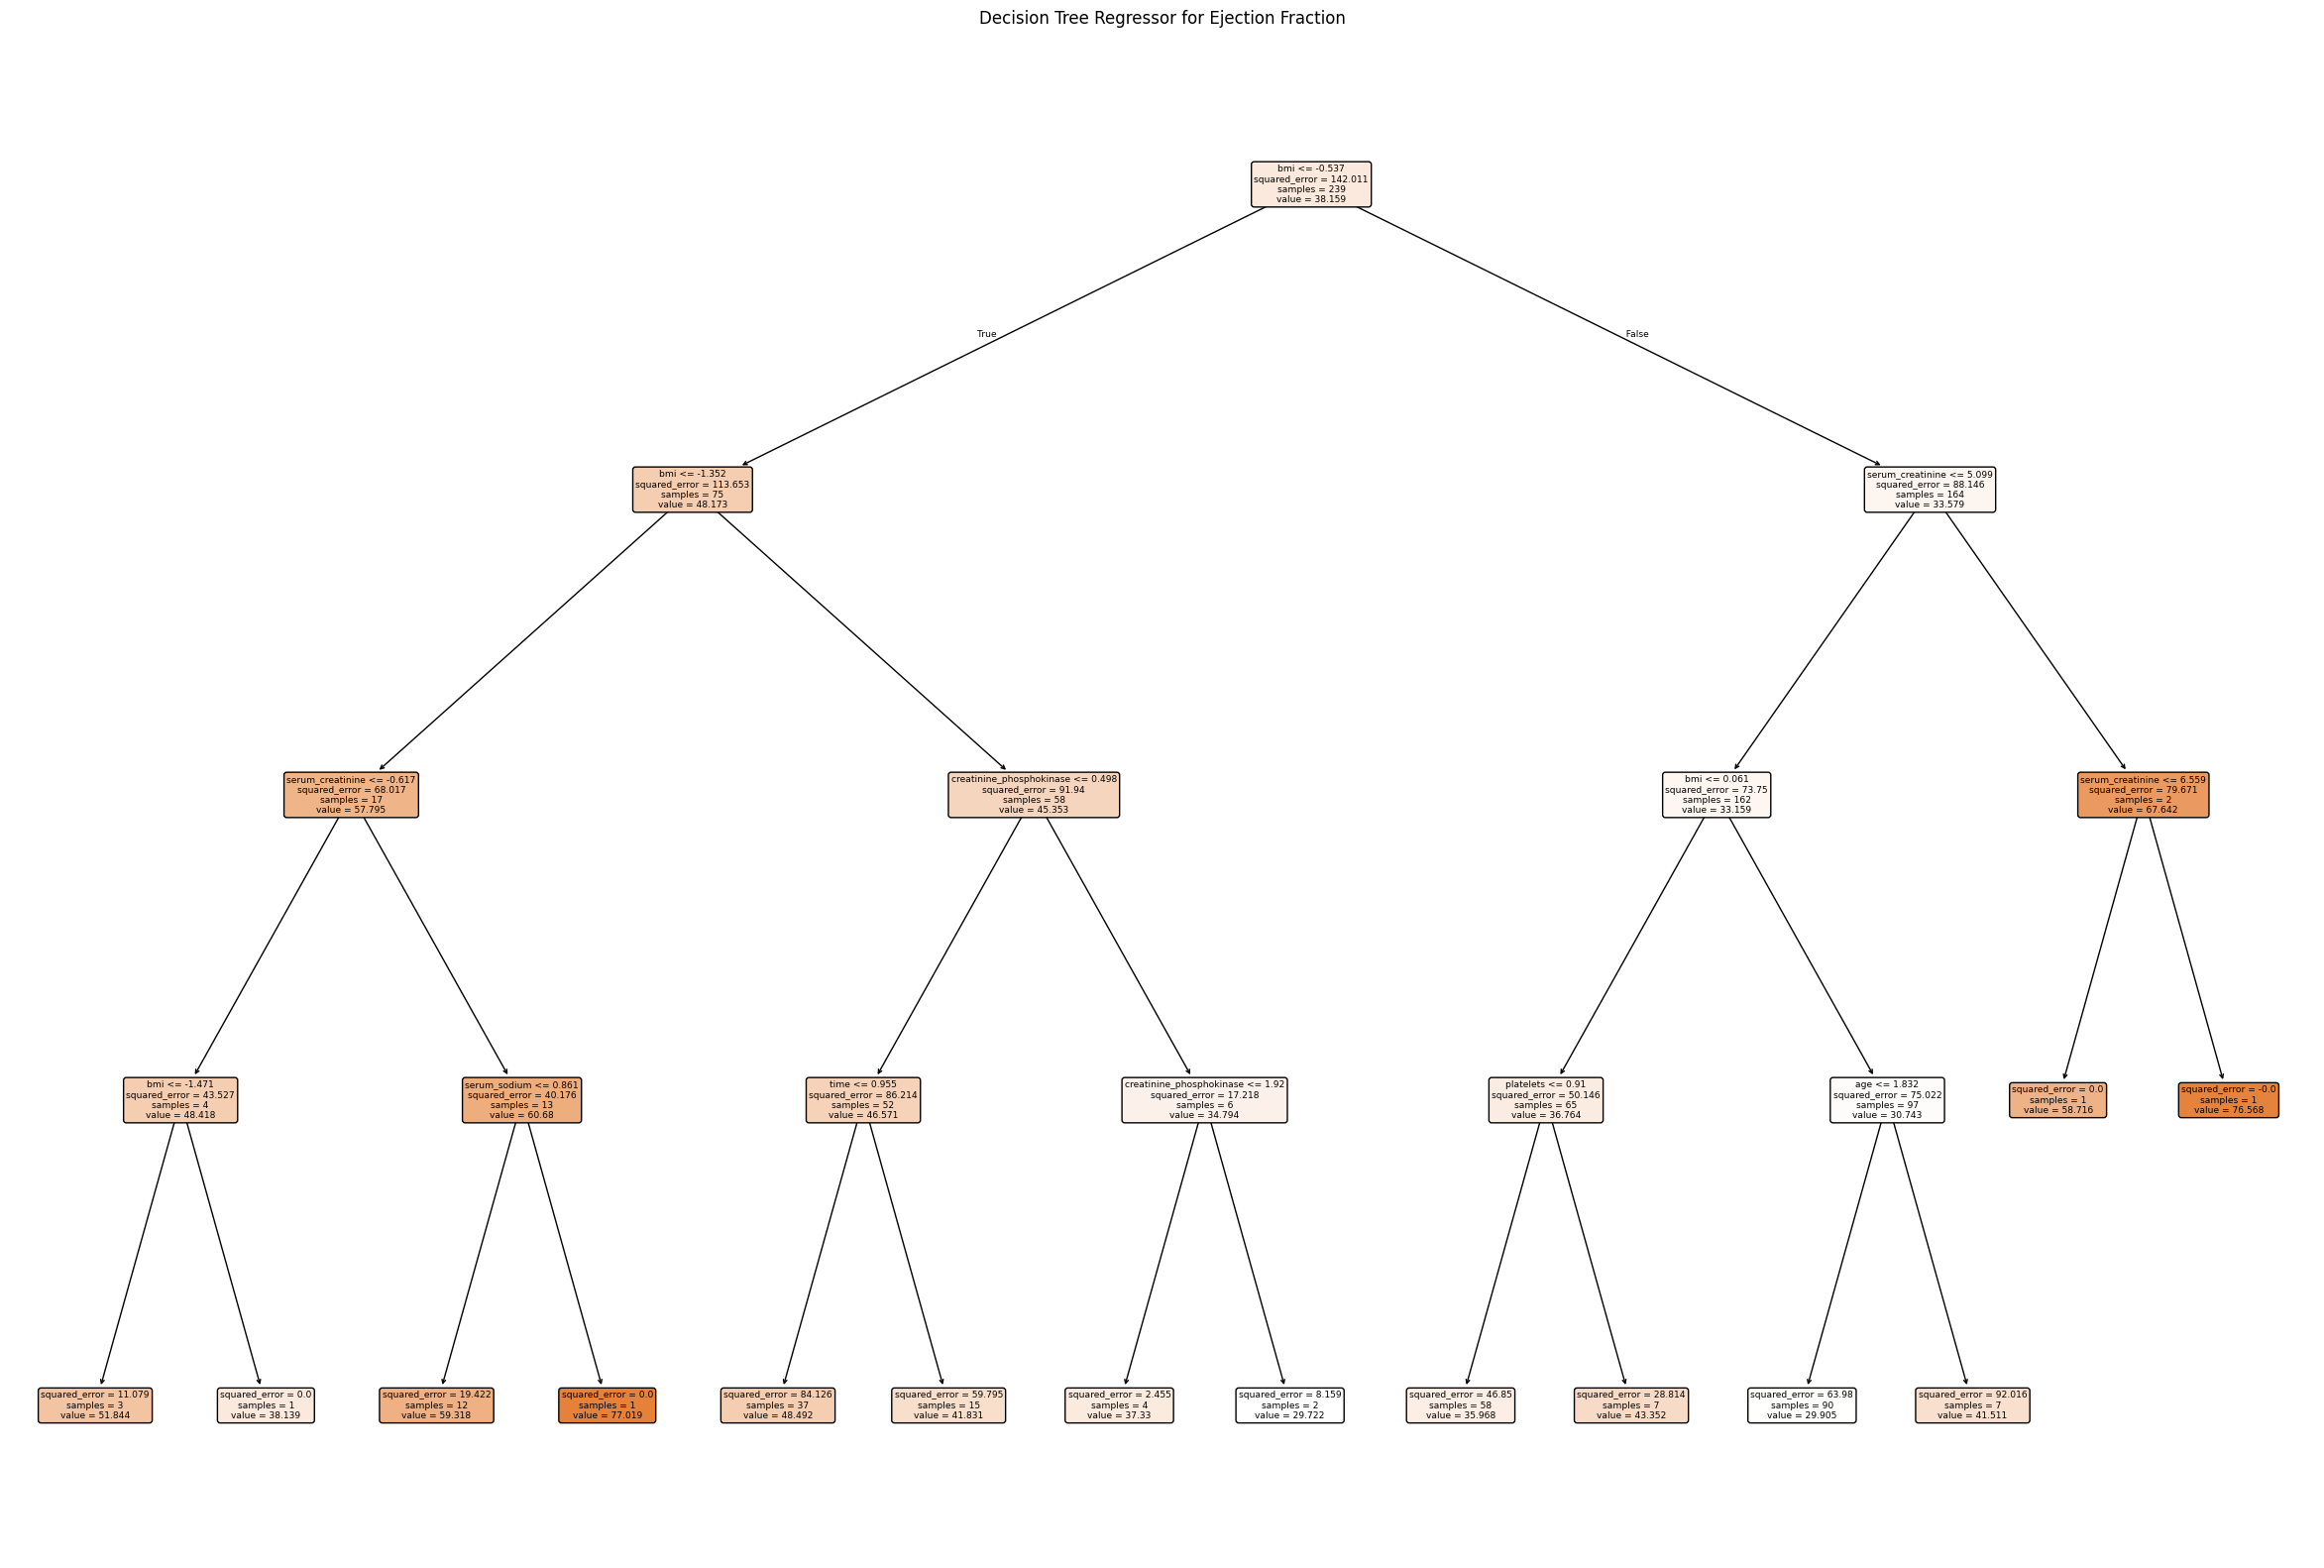

In [18]:
# Get feature names after encoding
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_vars)
all_feature_names = numeric_vars + list(encoded_feature_names)

# Plot the tree
reg_tree = pipeline.named_steps['regressor']

plt.figure(figsize=(30, 20))
plot_tree(reg_tree,
          feature_names=all_feature_names,
          filled=True,
          rounded=True,)
plt.title("Decision Tree Regressor for Ejection Fraction")
plt.show()

# Random Forest

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Load data
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Test Accuracy: 0.933

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



## Hyperparameters

Recommended values are $m=p/3$ for regression and $m=\sqrt{p}$ for classification, with m being the % of features to keep (max_features)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 3, 5, 10],
    'max_features': ['sqrt', 'log2', None]  # or you can use int values
}

# Setup grid search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Accuracy: {grid_search.best_score_:.3f}")

# Test performance
y_pred = best_rf.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}
Best CV Accuracy: 0.958

Test Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Out-Of-Bag evaluation



1.   For each training point, collect predictions from only the trees that didn’t see it.
2.  Compare these predictions to the true labels.
3.  Average the accuracy (or other metric) over all such point






In [21]:
rf_oob = RandomForestClassifier(oob_score=True, n_estimators=100, random_state=42)
rf_oob.fit(X, y)
print("OOB Score:", rf_oob.oob_score_)

OOB Score: 0.9533333333333334


The scikit-learn OOB implementation is limited to accuracy for classification and R^2 for regression. Other metrics can be computed by accessing the OOB predictions:

In [22]:
from sklearn.metrics import f1_score

y_pred_oob = np.argmax(rf_oob.oob_decision_function_, axis=1)
f1 = f1_score(y, y_pred_oob, average='macro')
print(f"OOB F1 Score (macro): {f1:.3f}")

OOB F1 Score (macro): 0.953


## Interpretation

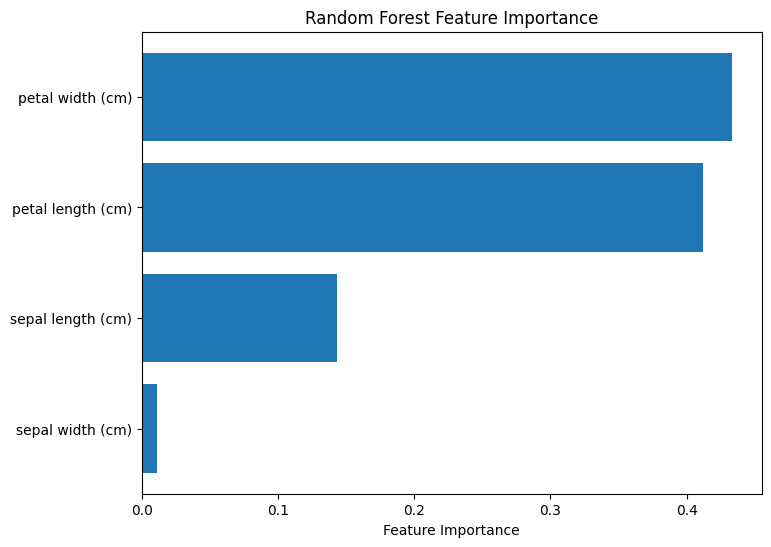

In [23]:
importances = best_rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Partial Dependency Plots

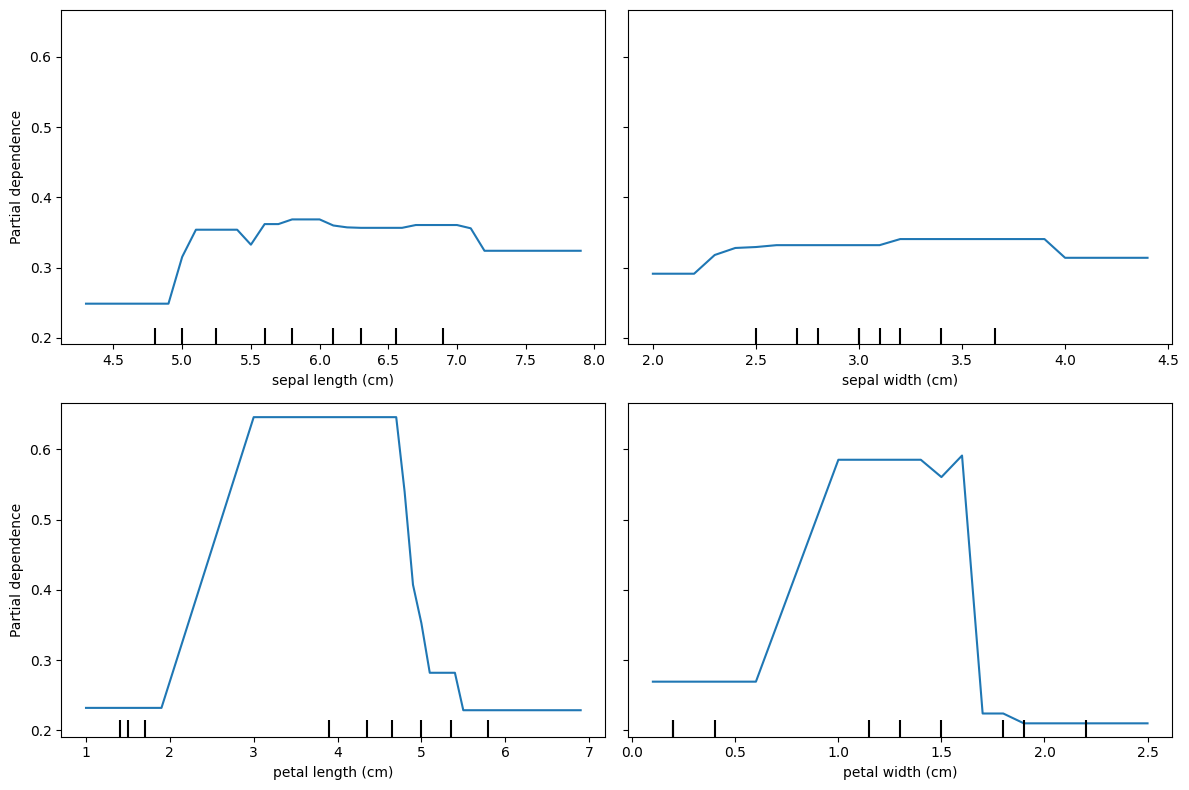

In [24]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Adjust as needed
PartialDependenceDisplay.from_estimator(best_rf, X, features=[0, 1, 2, 3], feature_names=feature_names, target=1, ax=ax)
plt.tight_layout()
plt.show()

## Random Forest for Regression

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Separate features/target
X = df.drop(columns='ejection_fraction')
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first'), categorical_vars)
])

# Full pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Adjusted R²
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = preprocessor.fit(X_train).transform(X_train).shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Output
rf_model = pipeline.named_steps['model']
print(f"OOB R²: {rf_model.oob_score_:.3f}")
print(f"R²:        {r2:.3f}")
print(f"Adjusted R²:    {adj_r2:.3f}")
print(f"MSE:            {mse:.2f}")
print(f"MAE:            {mae:.2f}")


OOB R²: 0.416
R²:        0.567
Adjusted R²:    0.445
MSE:            75.41
MAE:            6.92


# Gradient Boosting

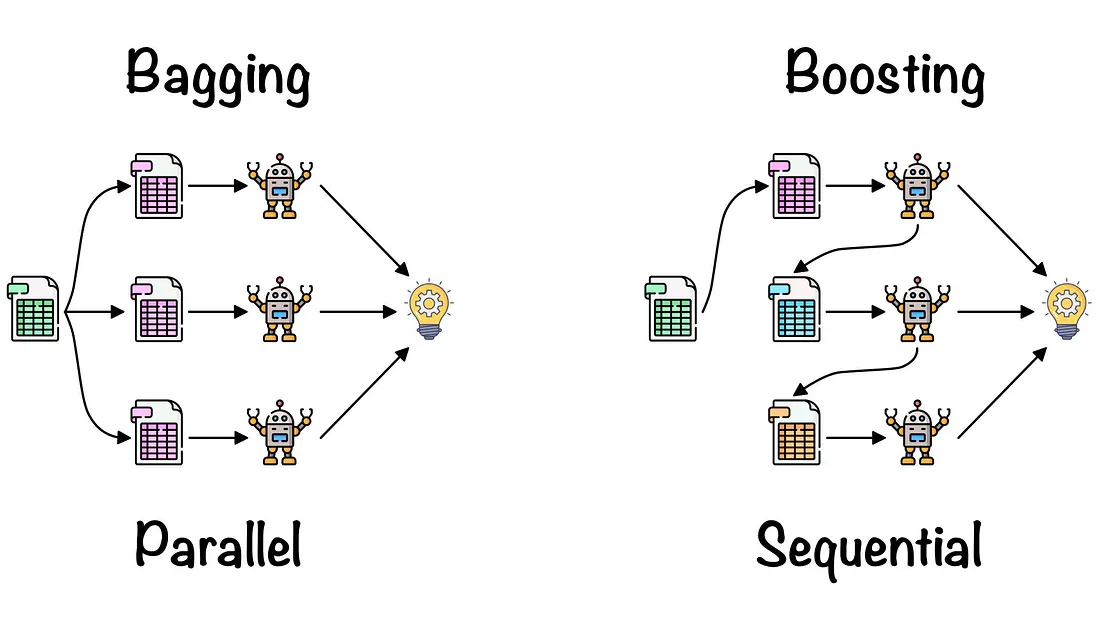

## Gradient Boosting Regressor

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# Separate features/target
X = df.drop(columns='ejection_fraction')
y = df['ejection_fraction']

numeric_vars = num_vars.copy()
numeric_vars.remove('ejection_fraction')
categorical_vars = cat_vars.copy()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_vars),
    ('cat', OneHotEncoder(drop='first'), categorical_vars)
])

# Pipeline with Gradient Boosting
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Adjusted R²
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = preprocessor.fit(X_train).transform(X_train).shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Output
print(f"R²:        {r2:.3f}")
print(f"Adjusted R²:    {adj_r2:.3f}")
print(f"MSE:            {mse:.2f}")
print(f"MAE:            {mae:.2f}")


R²:        0.486
Adjusted R²:    0.398
MSE:            88.24
MAE:            7.57


## Gradient Boosting Classifier

Test Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



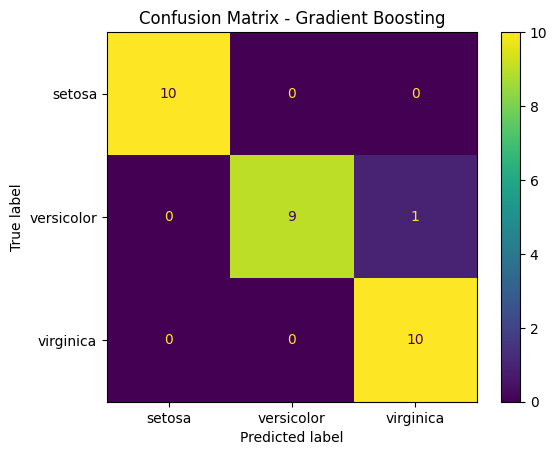

In [27]:
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Load iris data
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Gradient Boosting fit
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

# Predict
y_pred = gb.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

ConfusionMatrixDisplay.from_estimator(gb, X_test, y_test, display_labels=target_names)
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()


In [29]:
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time']#, 'rehospitalizations']
num_vars.remove('ejection_fraction')

X = df[num_vars]
y = df['ejection_fraction']

model.fit(X,y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [30]:
y_pred = model.predict(X)
residuals = y - y_pred

299

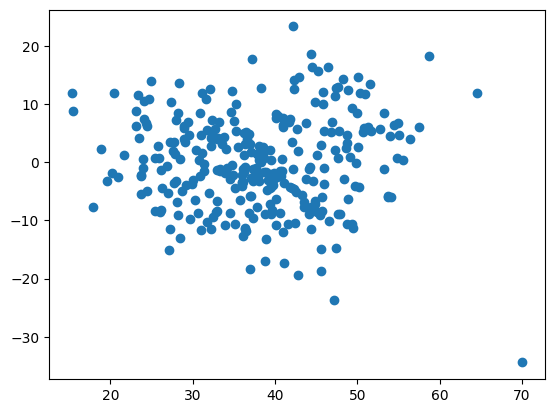

In [31]:
#plotting
import matplotlib.pyplot as plt
plt.scatter(y_pred, residuals)
len(residuals)

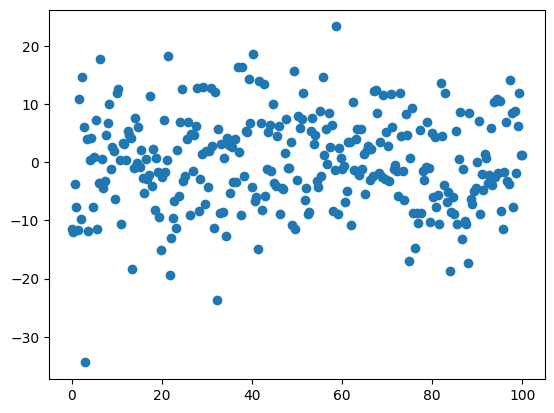

In [33]:
x_plotting = np.linspace(0, 100, 299)
plt.scatter(x_plotting, residuals)


## Manual implementation

In [34]:
from sklearn.tree import DecisionTreeRegressor

# -----------------------------
# Data generation and plotting
# -----------------------------

def GenerateData():
    X = np.arange(0, 50).reshape(-1, 1)

    y = np.concatenate([
        np.random.uniform(10, 15, 10),
        np.random.uniform(20, 25, 10),
        np.random.uniform(0, 5, 10),
        np.random.uniform(30, 32, 10),
        np.random.uniform(13, 17, 10)
    ])

    return X, y.reshape(-1, 1)

def PlotModel(X, y, yp, title='', fn=None):
    plt.figure(figsize=(20,10))
    plt.scatter(X, y, color='blue', label='True y')
    plt.plot(X, yp, color='red', label='Prediction')
    plt.xlim([-1, 51])
    plt.ylim([-1, 35])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    if fn:
        plt.savefig(fn)
    plt.show()

def PlotResidual(X, residuals, title='', fn=None):
    plt.figure(figsize=(20,10))
    plt.scatter(X, residuals, color='green')
    plt.xlim([-1, 51])
    plt.ylim([-25, 25])
    plt.xlabel('x')
    plt.ylabel('residual')
    plt.title(title)
    if fn:
        plt.savefig(fn)
    plt.show()

# -----------------------------
# Gradient Boosting Logic
# -----------------------------

def GradientBoosting(X, y, n_iterations=30, max_depth=1, plot=True):
    # Initial prediction is the mean
    initial_pred = np.ones_like(y) * y.mean()
    prediction = initial_pred.copy()

    if plot:
        PlotModel(X, y, initial_pred, title='Iteration #1 - Initial Mean')
        PlotResidual(X, y - prediction, title='Iteration #1 - Residual')

    for i in range(n_iterations):
        residuals = y - prediction

        stump = DecisionTreeRegressor(max_depth=max_depth)
        stump.fit(X, residuals)
        update = stump.predict(X).reshape(-1, 1)

        prediction += update

        if plot and (i+2)%5==0:
            PlotModel(X, y, prediction, title=f'Iteration #{i+2} - Model')
            PlotResidual(X, y - prediction, title=f'Iteration #{i+2} - Residual')

    return prediction

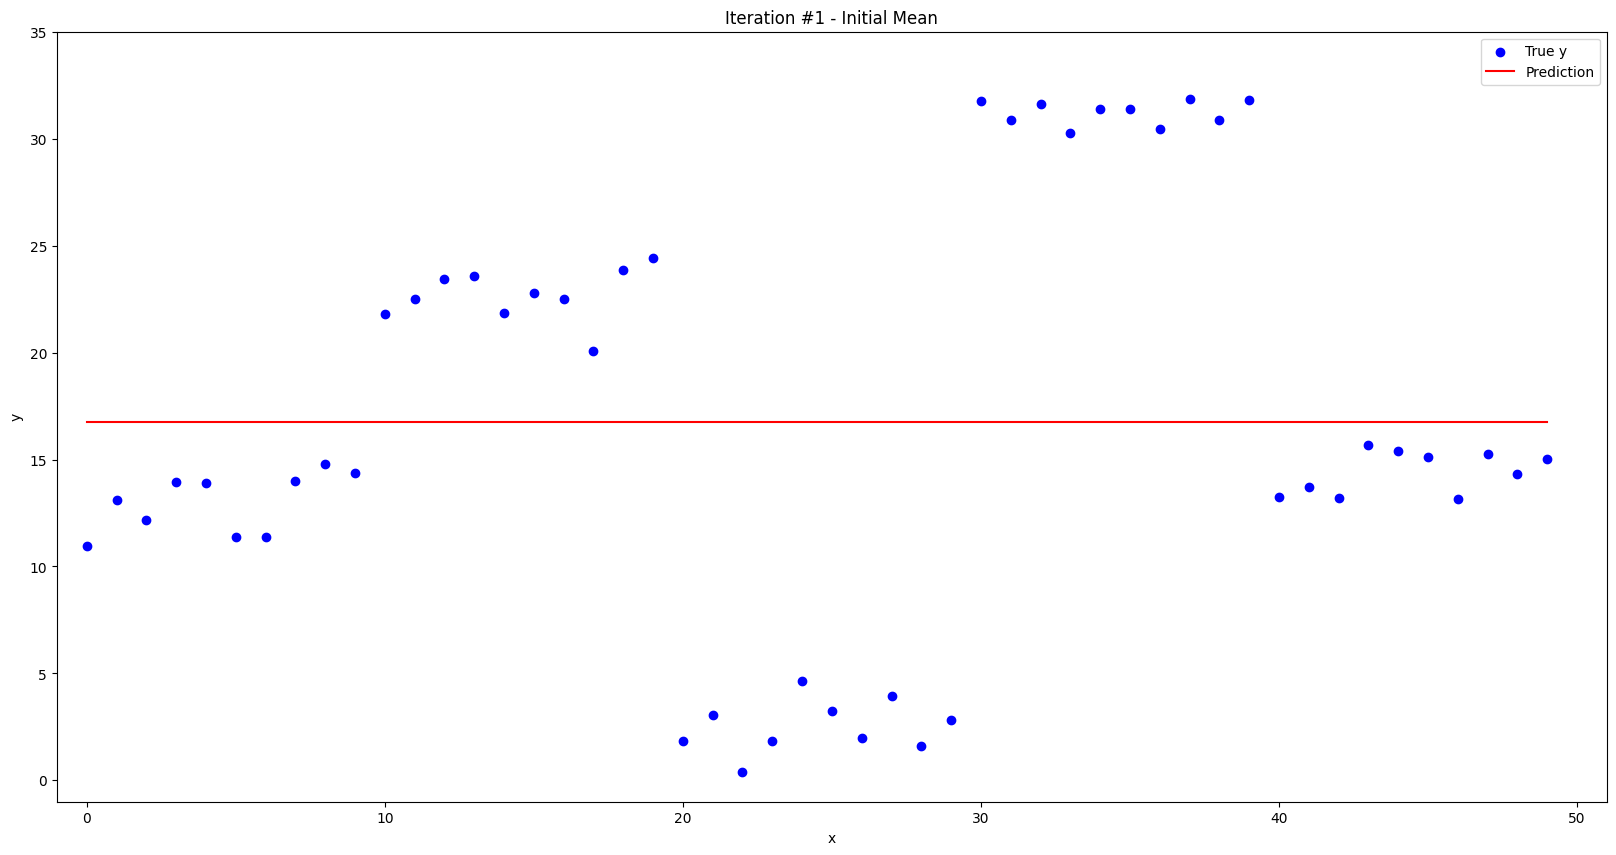

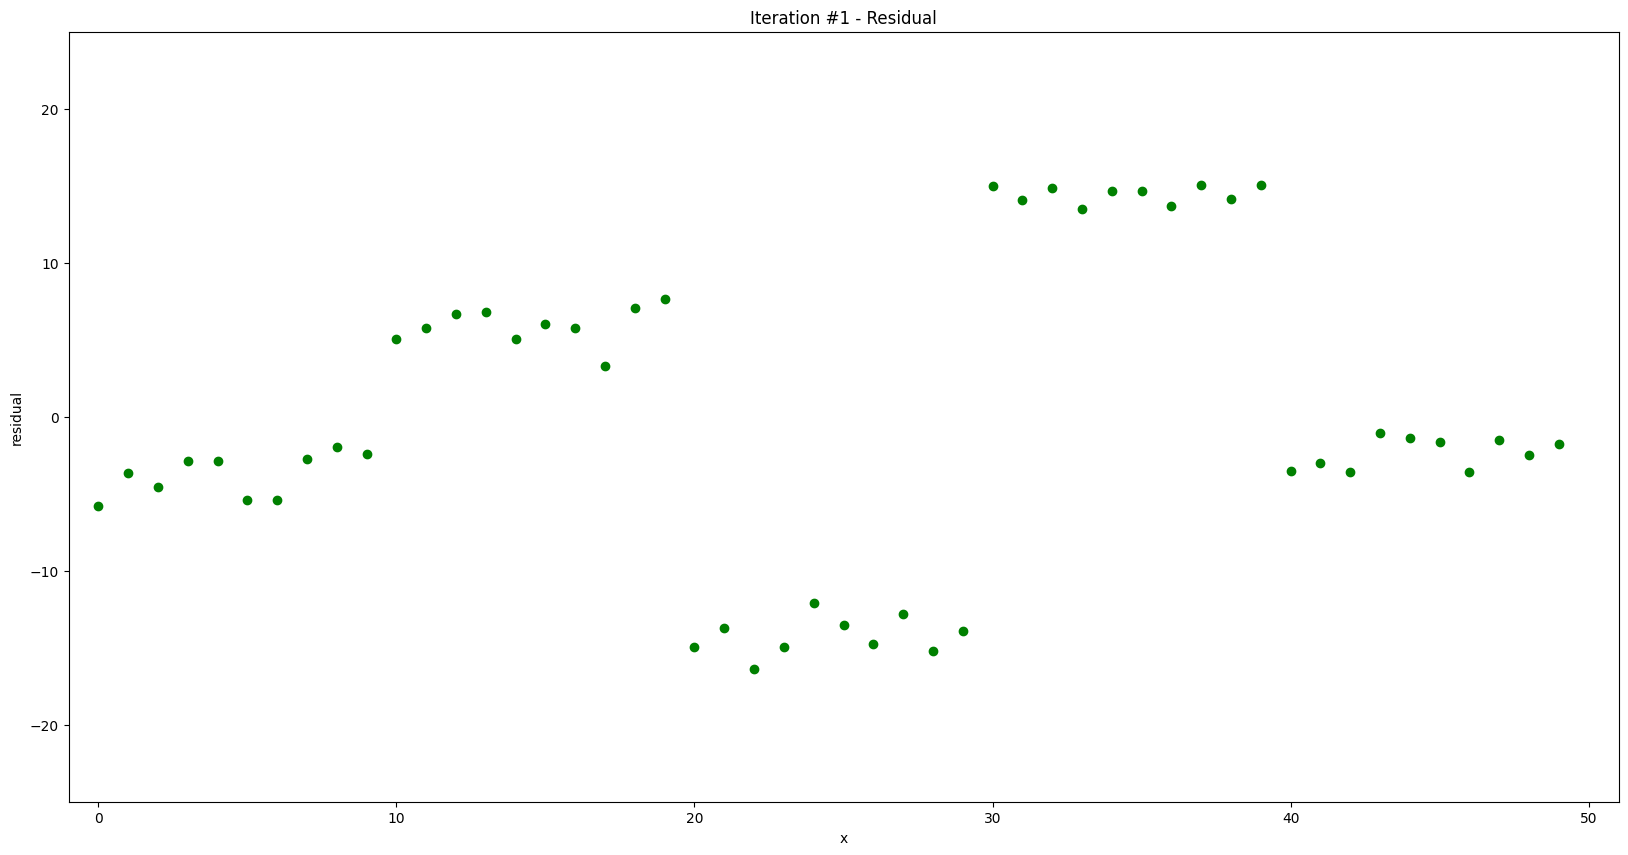

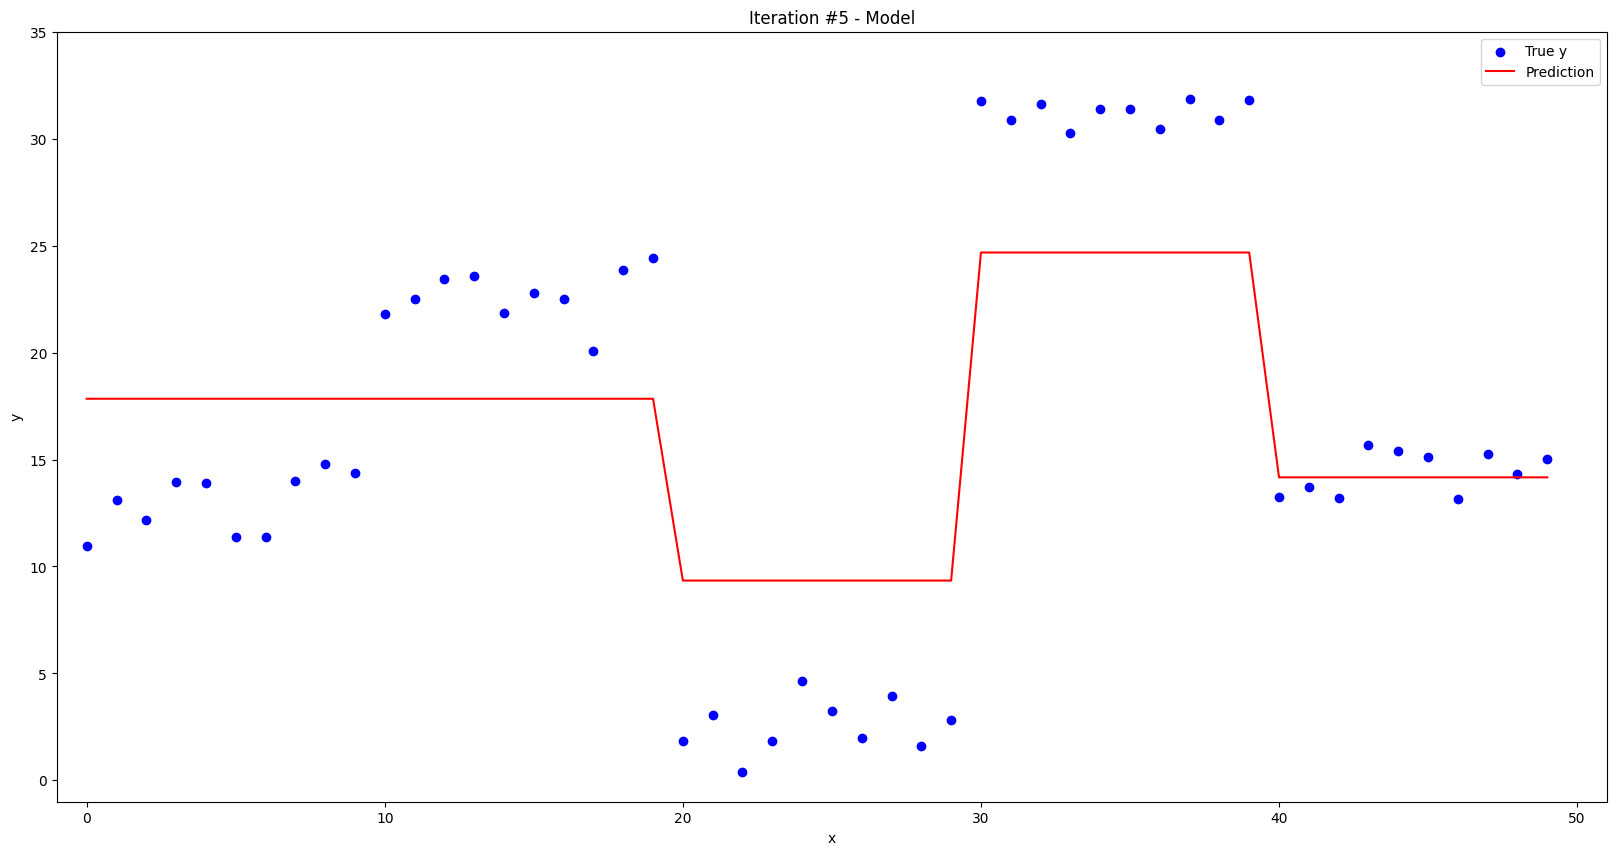

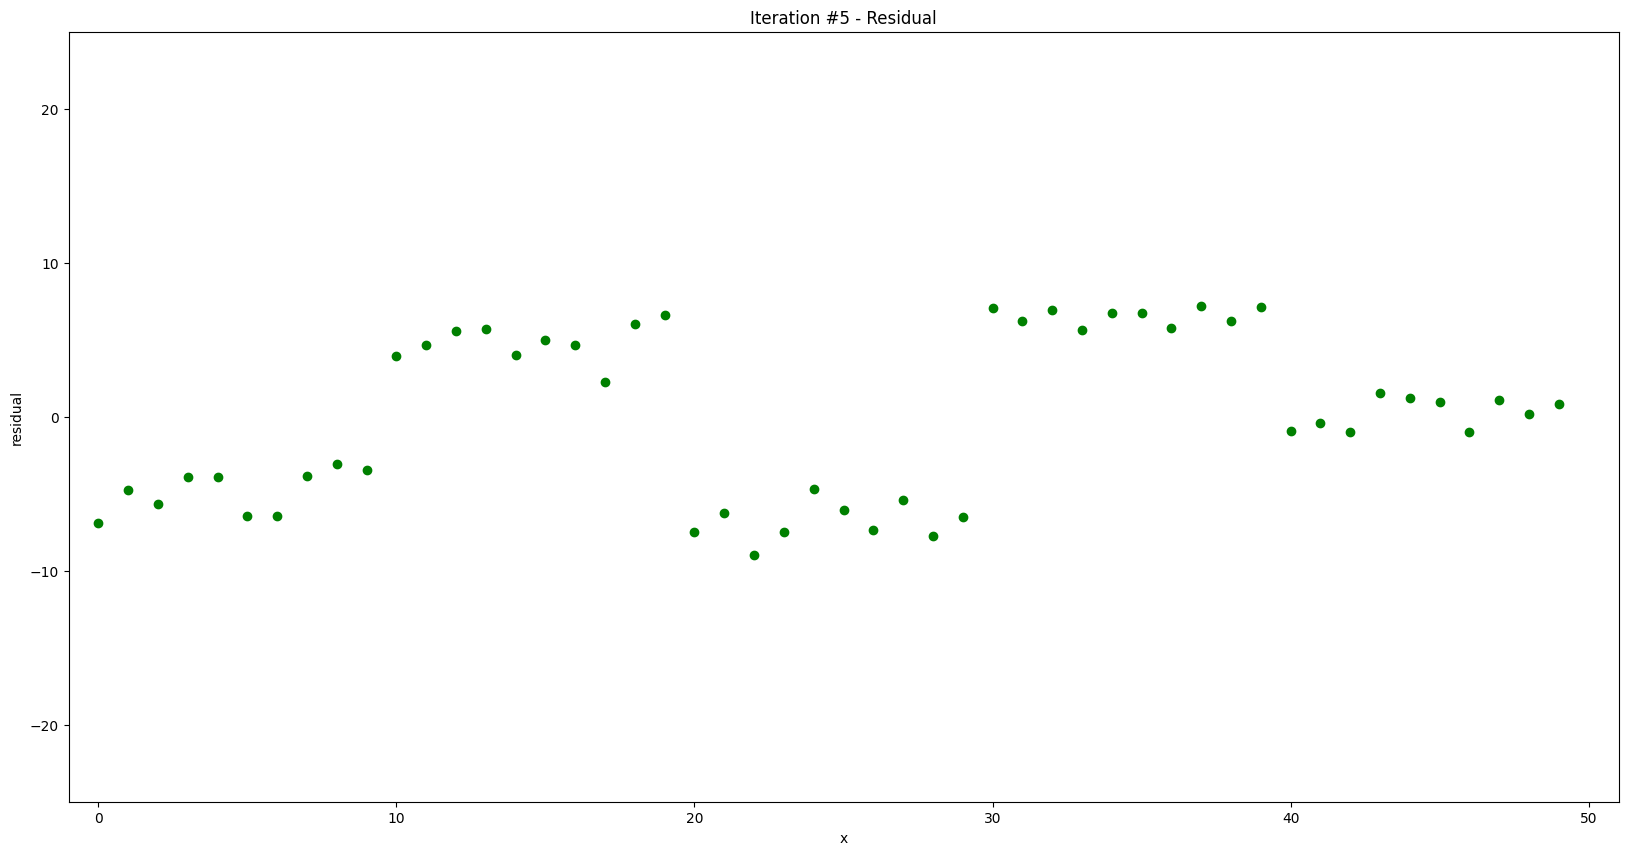

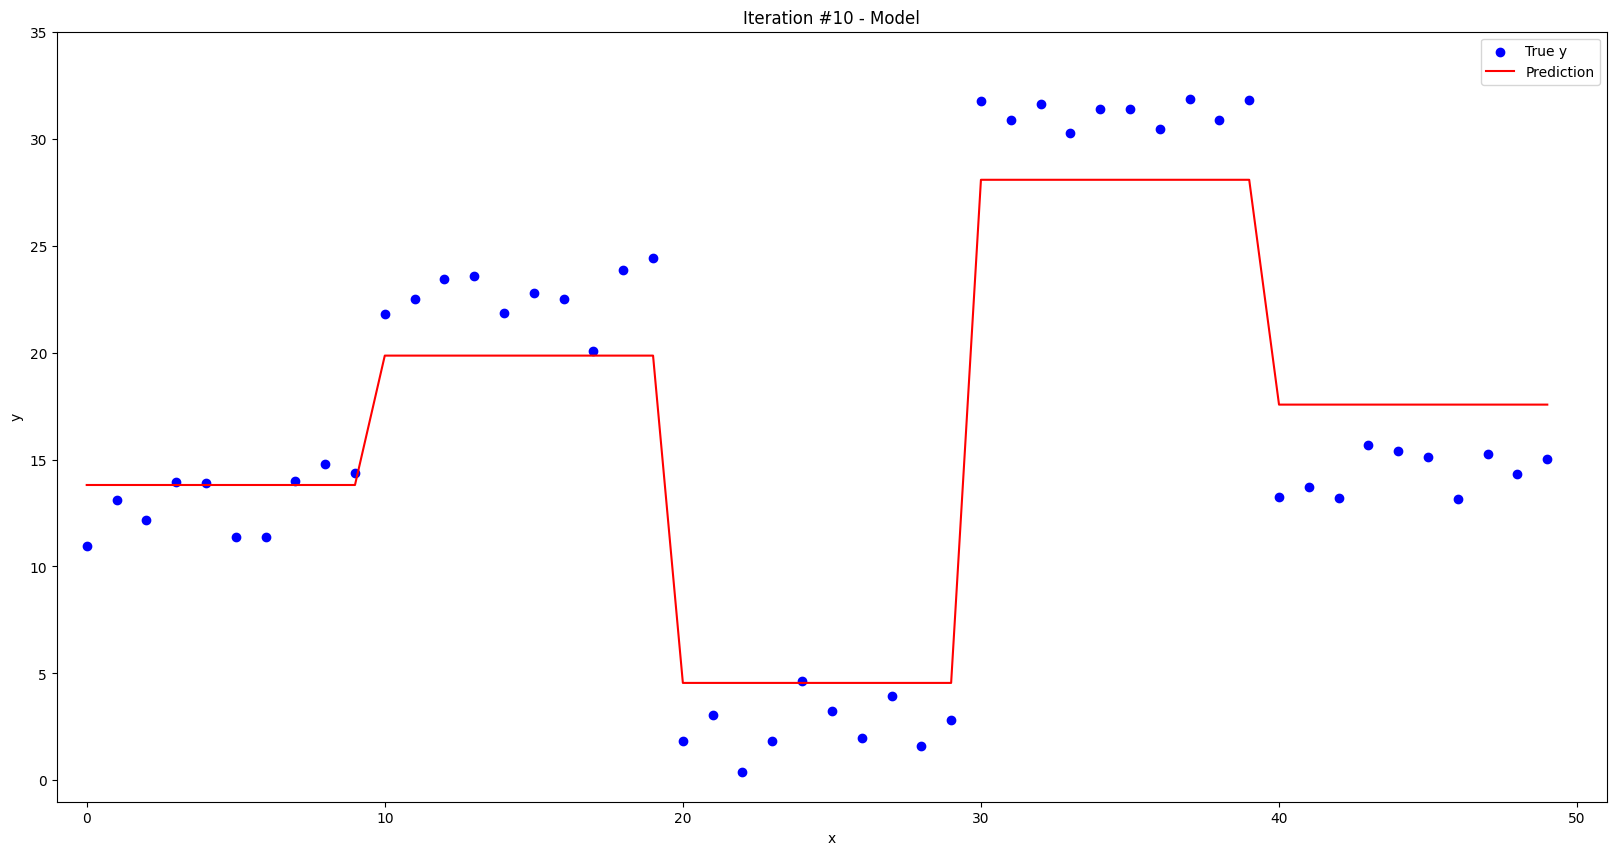

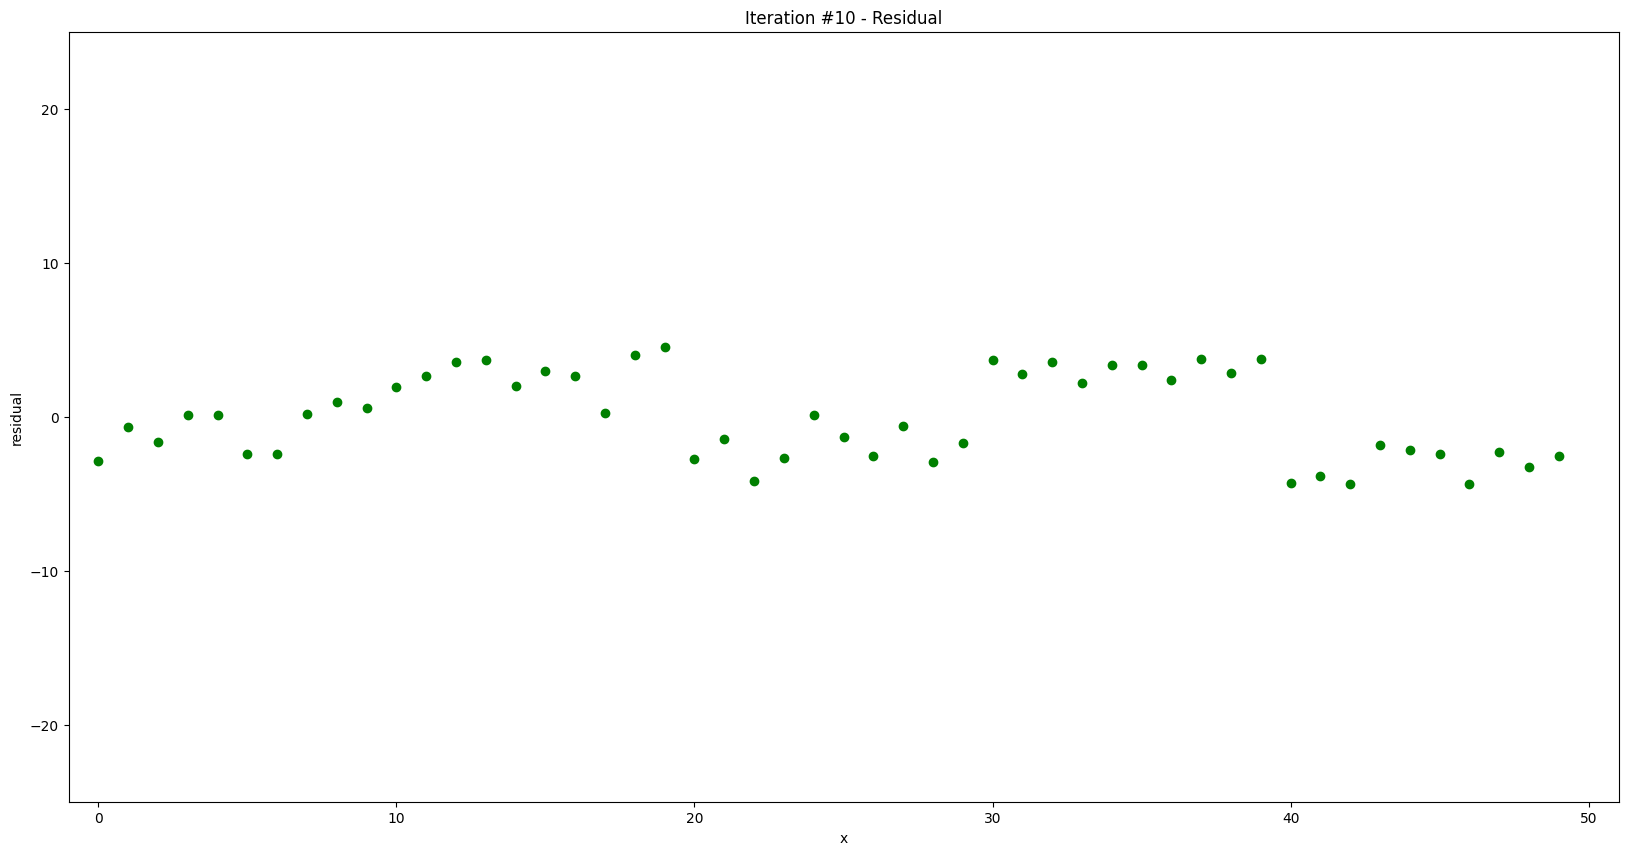

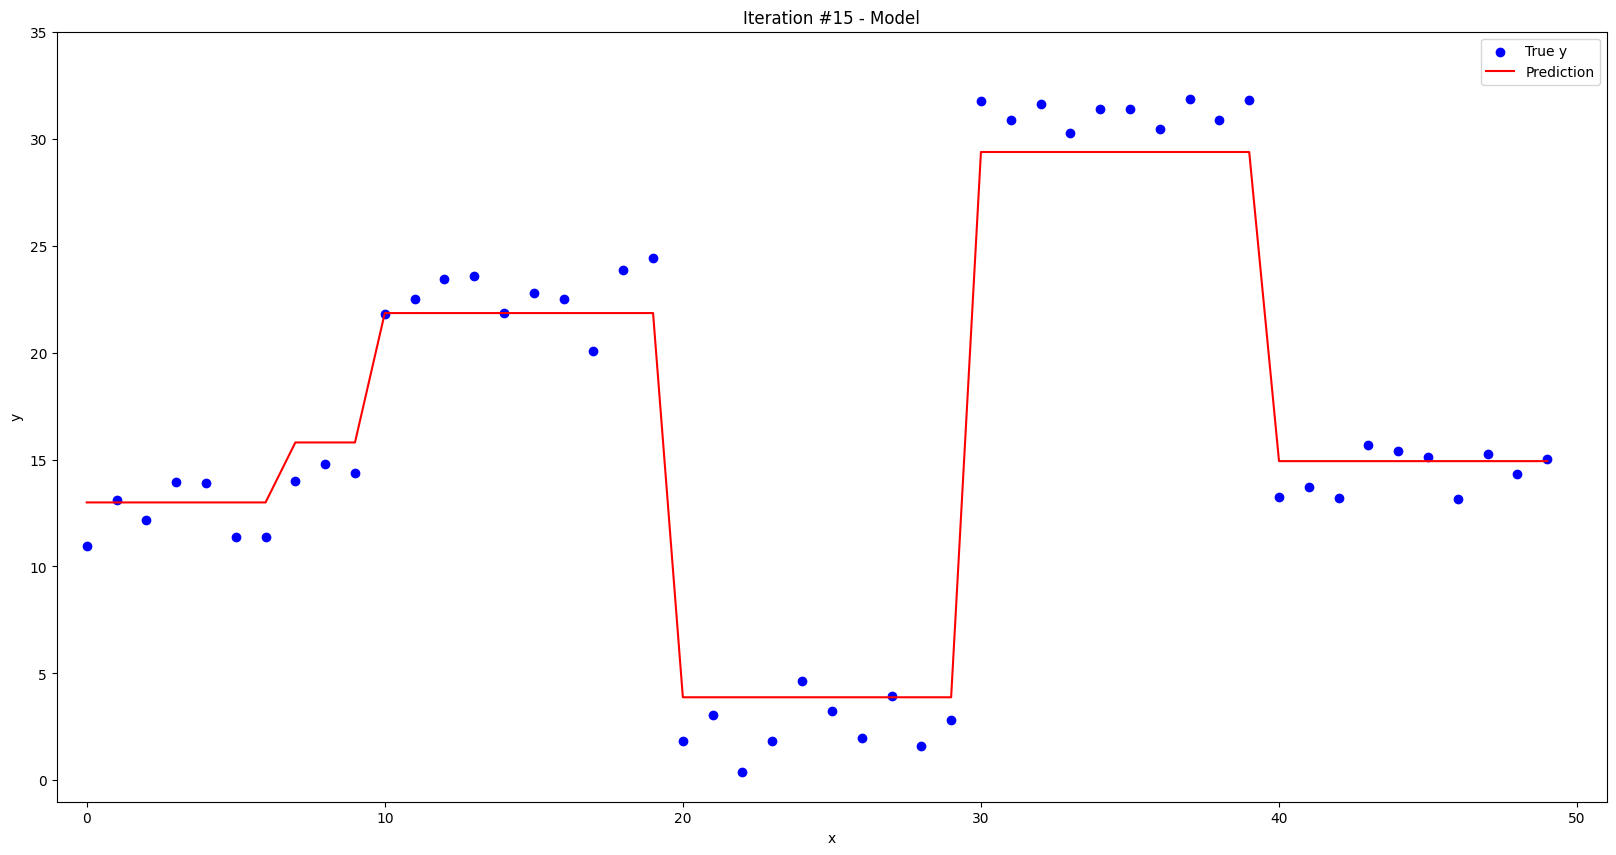

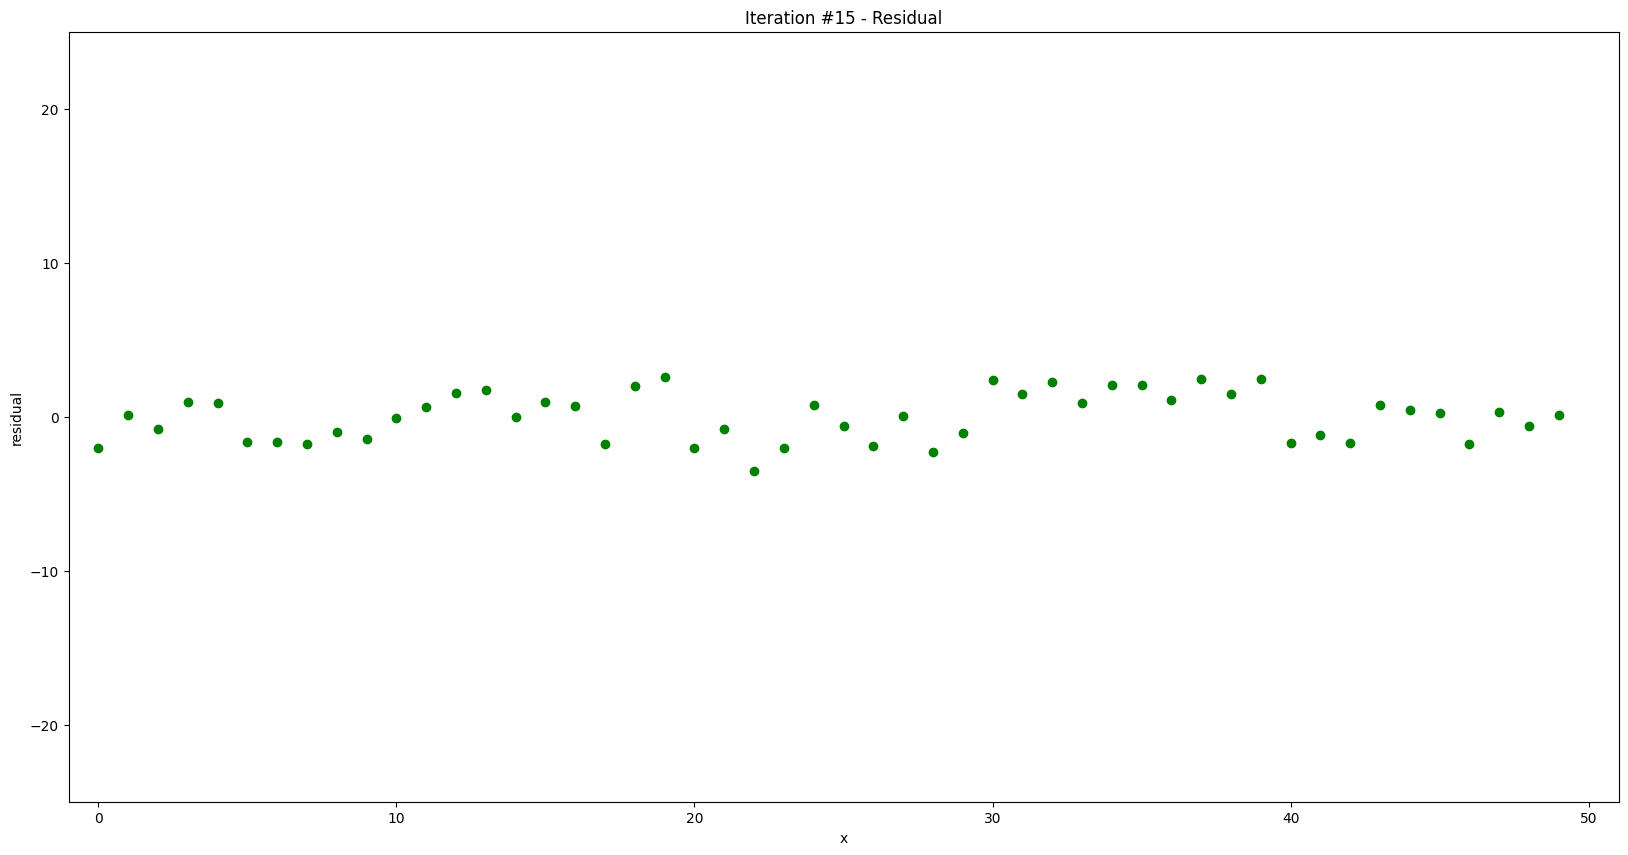

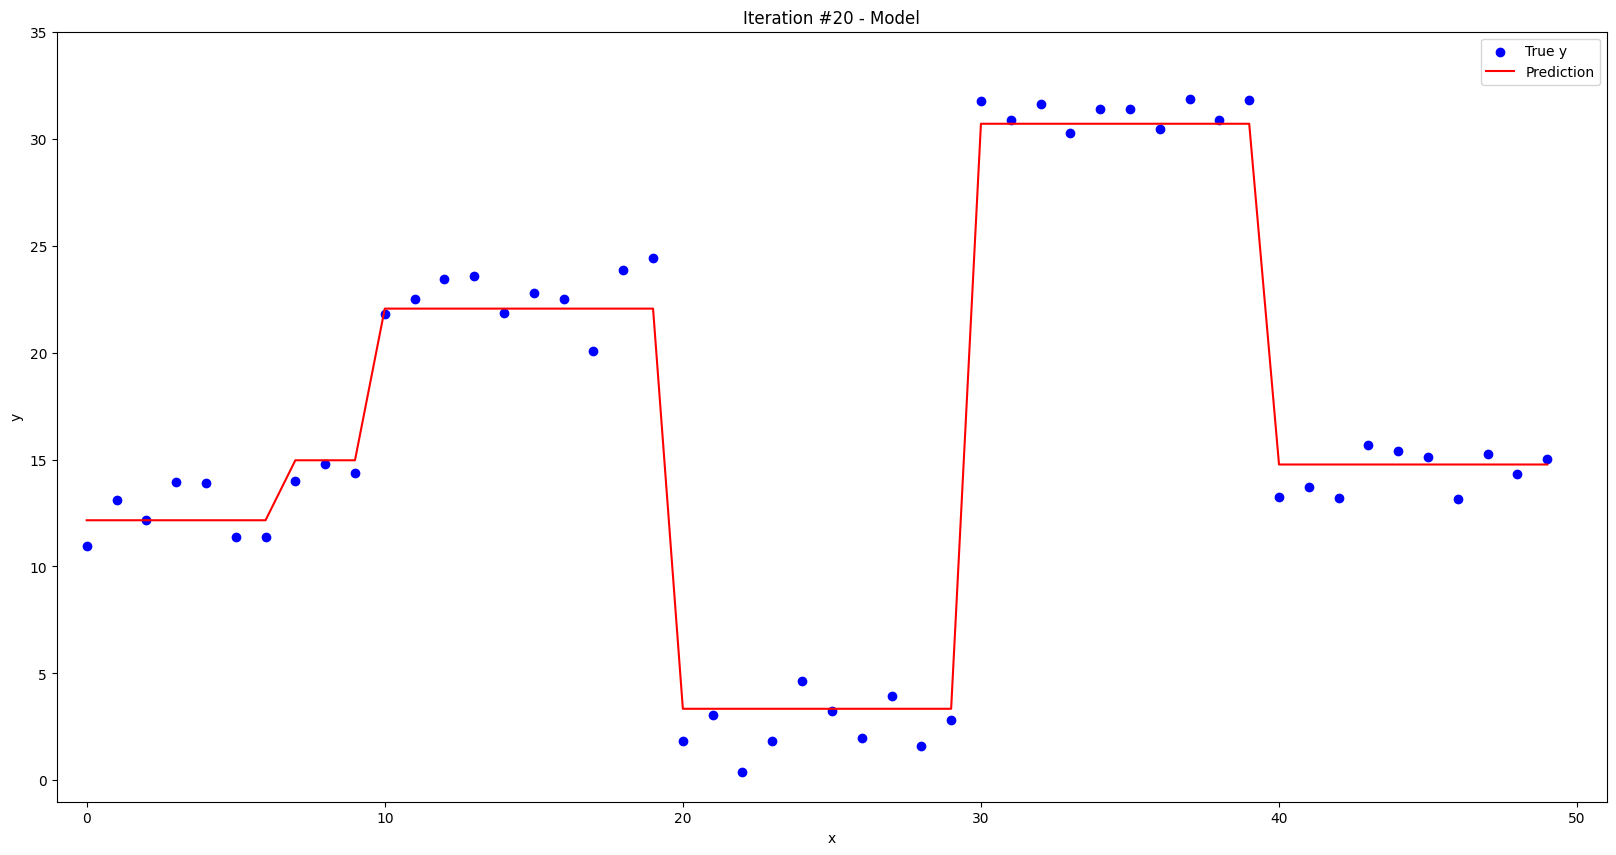

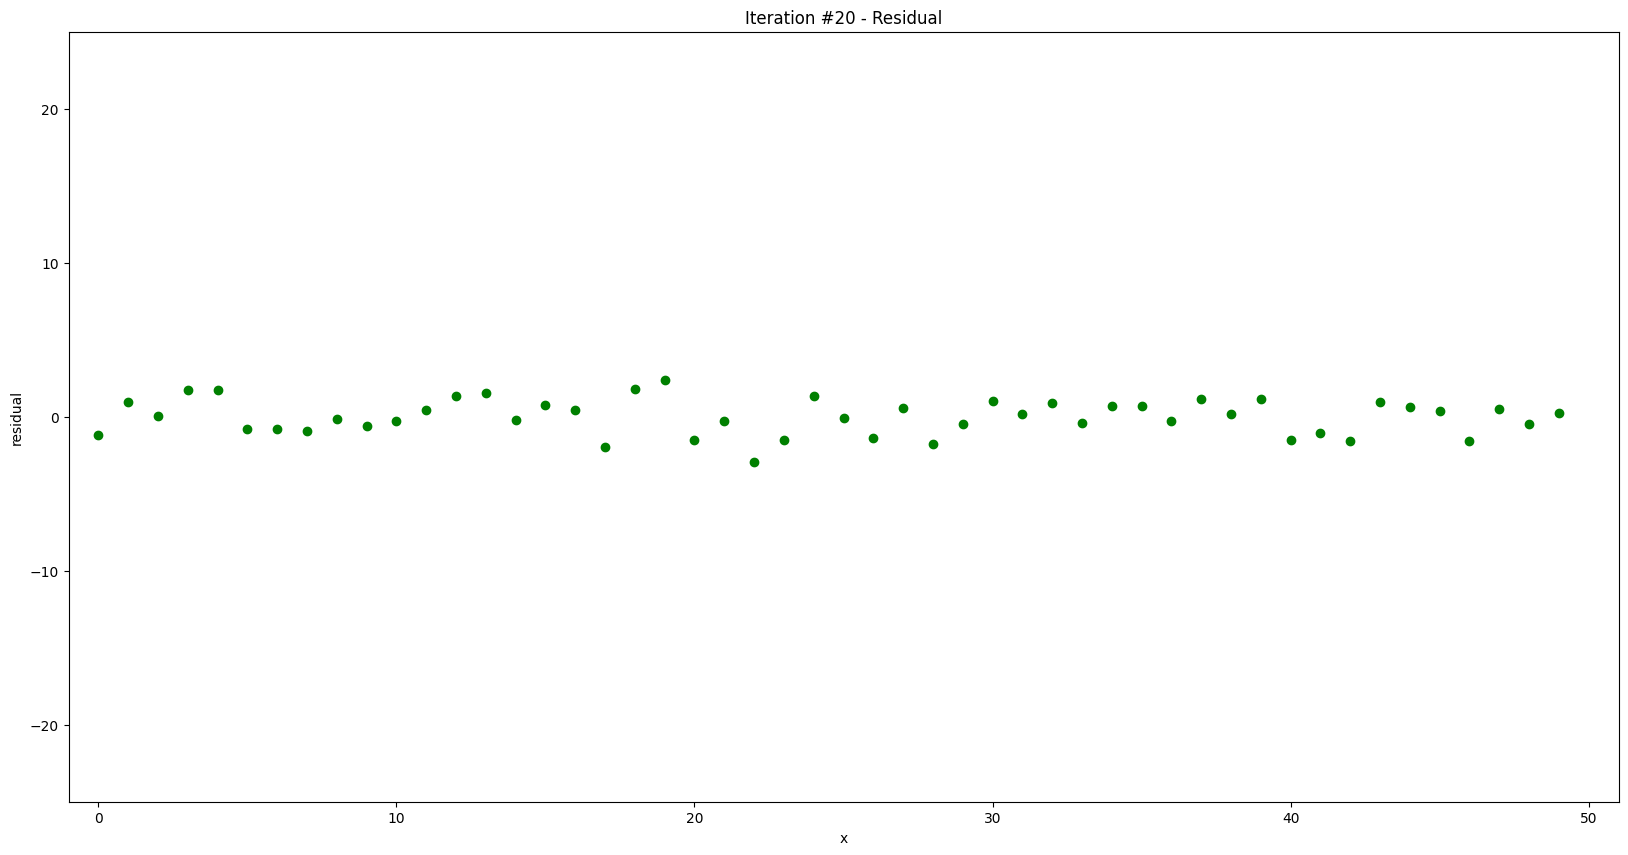

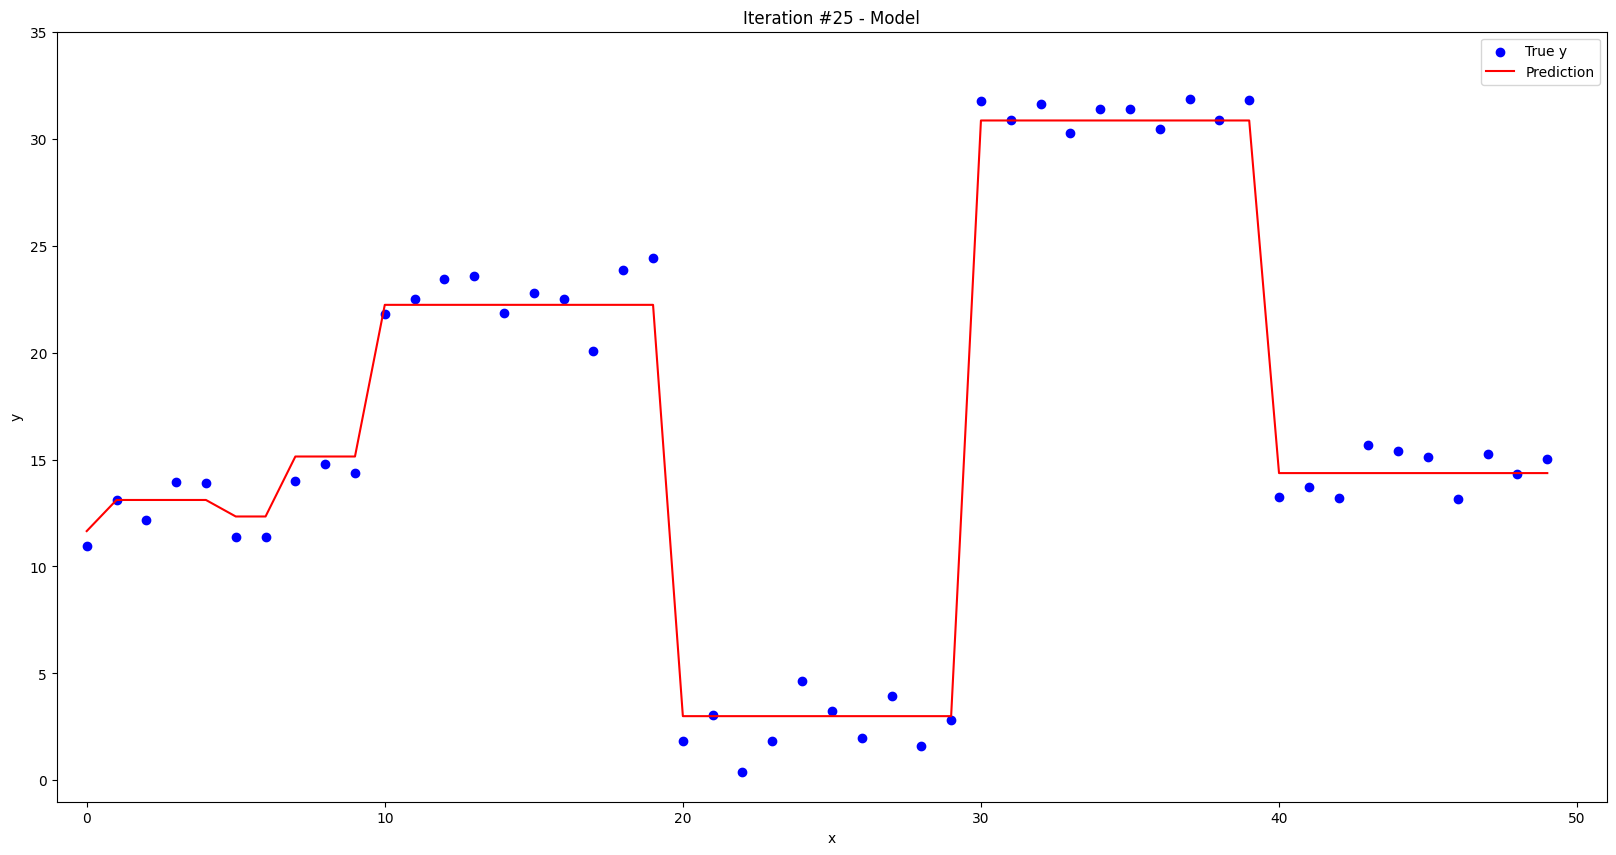

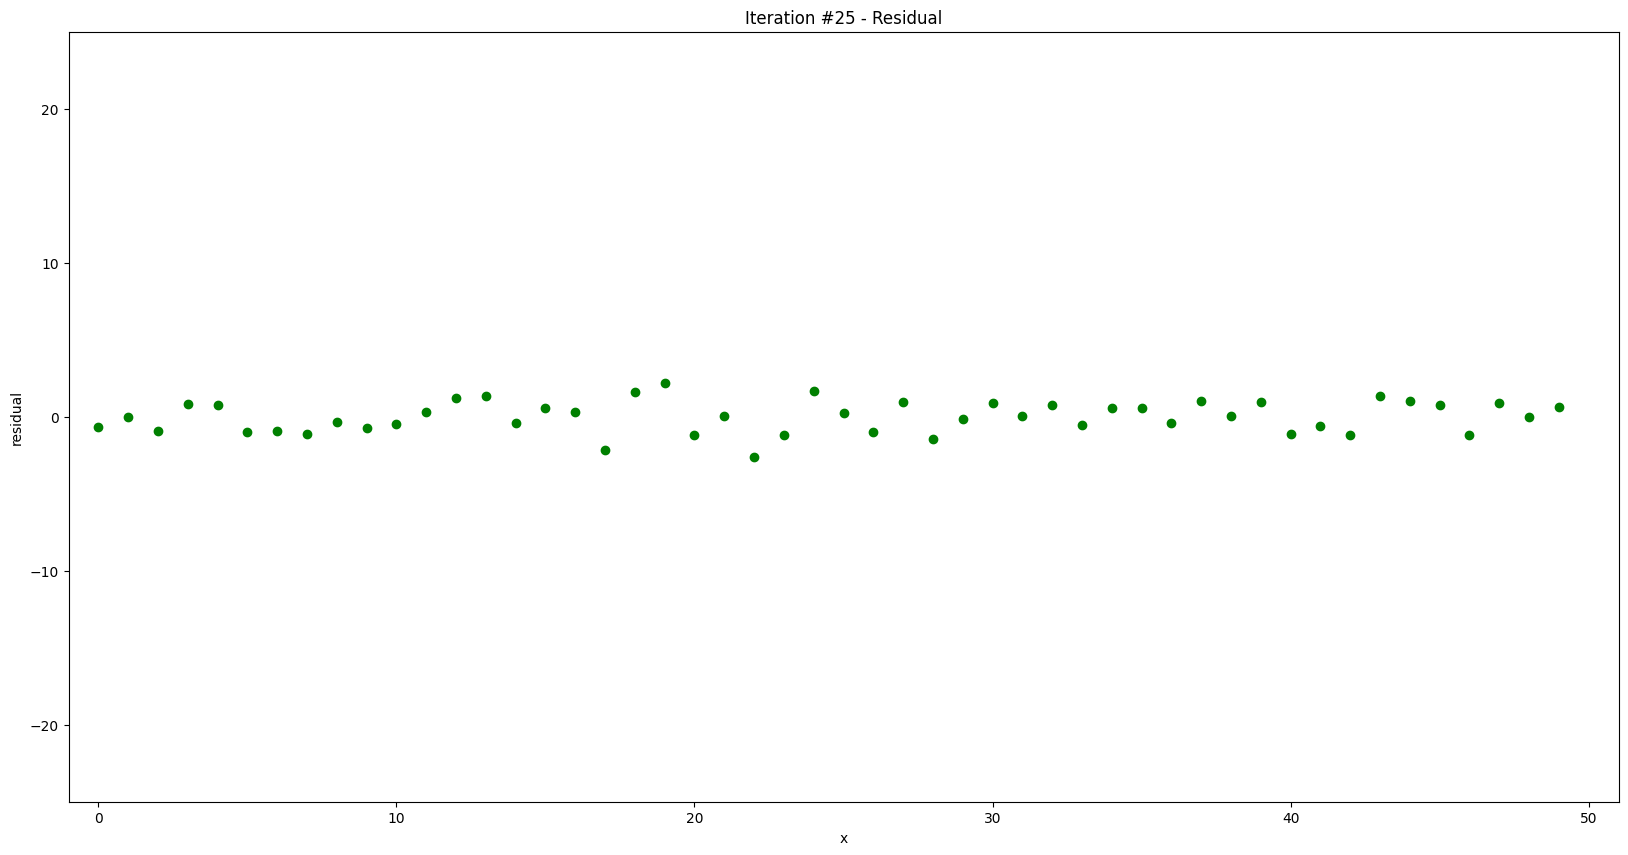

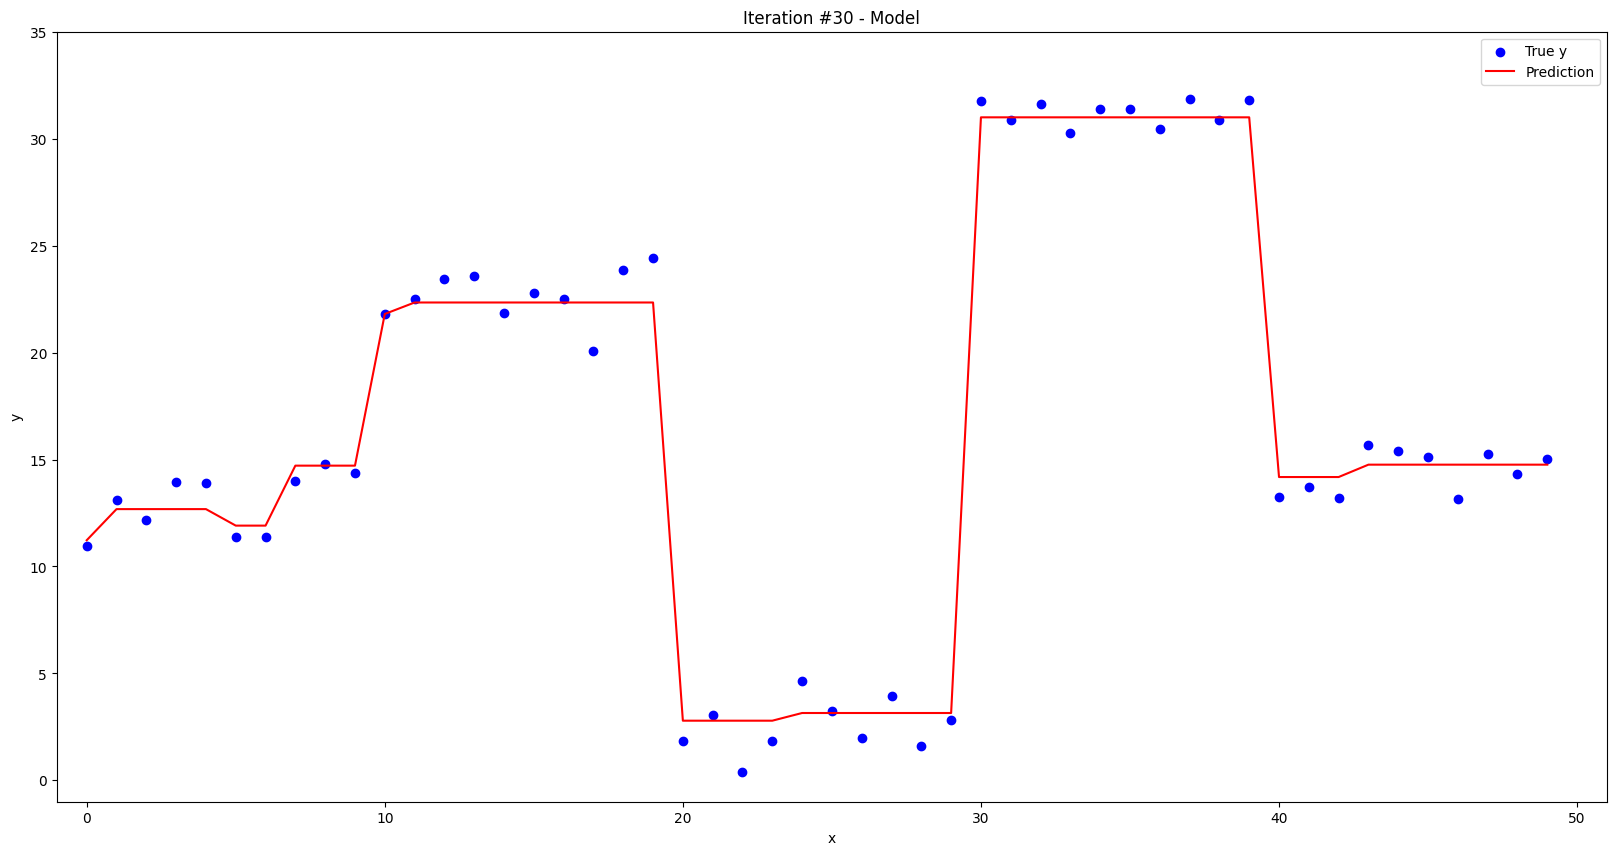

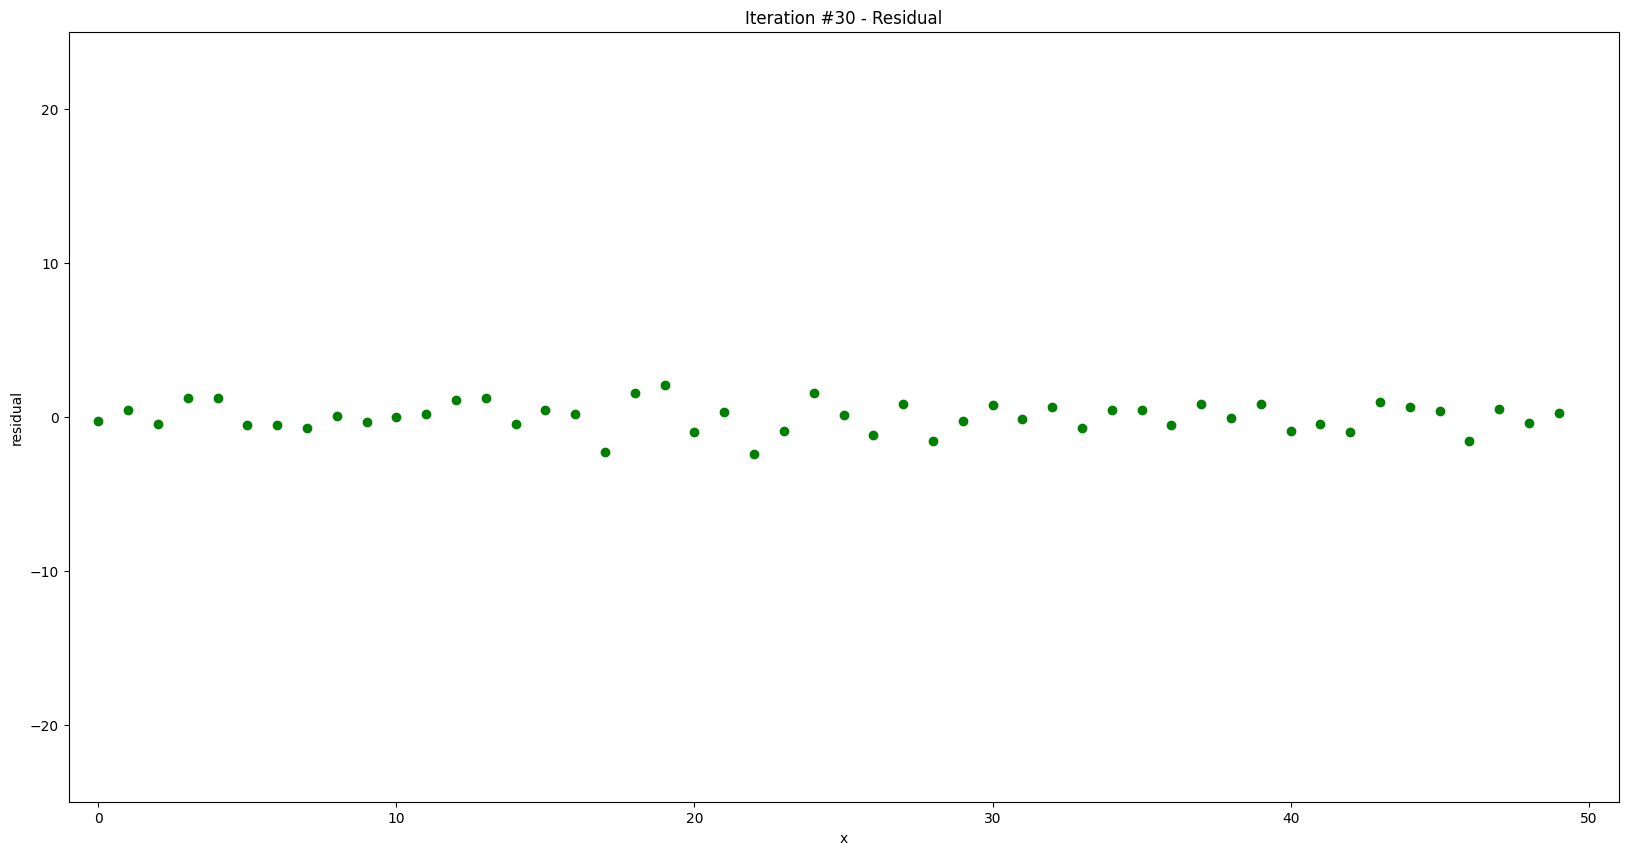

In [35]:
X, y = GenerateData()
final_prediction = GradientBoosting(X, y, n_iterations=30, max_depth=1, plot=True)

## XGBoost

Have a look at it, with its improvements over Gradient Boosting, if you are curious!

# Final Quiz

[Quiz link](https://app.wooclap.com/USSDDI?from=event-page)